<a href="https://colab.research.google.com/github/dianakorka/statistical_capacity/blob/main/HH_capacity_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessing Statistical Capacity to Compile Digital Development Statistics

## HH indicators

### Gathering and preparing data for analysis

I received data 4 different files: Household_data_avaialbility_Apr2025.xlsx, HH_availability_indicators_10_5.xlsx, HH Metadata_2015+.xlsx, Data_availability_by_indicator_and_year.csv.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import plotly.express as px
import re

In [ ]:
file_path = '/content/Household_data_availability_Apr2025.xlsx'

dfs = pd.read_excel(file_path, sheet_name=None)  # Reads all sheets into a dict

This file includes several sheets. I read them all together in one dataset, so I can easily access all series.

In [ ]:
for name, df in dfs.items():
    print(f"Sheet: {name}, Shape: {df.shape}")

Sheet: Overall availability, Shape: (238, 4)
Sheet: Availability by indicator, Shape: (187, 26)
Sheet: Availability by disaggregate, Shape: (212, 12)
Sheet: Country definition, Shape: (236, 16)


In [ ]:
df_1 = dfs['Overall availability']
df_2 = dfs['Availability by indicator']
df_2.drop(index=0, inplace=True)
df_3 = dfs['Availability by disaggregate']
df_4 = dfs['Country definition']

In [ ]:
merged_df = pd.merge(df_2, df_3, on='ISO3', how='outer')


In [ ]:
merged_df = pd.merge(df_1, merged_df, how='outer', left_on='Iso3', right_on='ISO3')

In [ ]:
merged_df = pd.merge(df_4, merged_df, left_on='IsoCode', right_on='ISO3', how='outer')

In [ ]:
# Drop any duplicate column (if it appears several times)
merged_df.drop(columns=['Iso3', 'Indicator', 'IsoCode', 'Target', 'Country_y', 'Country_x', 'Overall'], inplace=True)

In [ ]:
merged_df.columns

Index(['ShortName', 'RegionName', 'CountryType', 'ItuMember', 'LDC', 'LLDC',
       'SIDS', 'M49Region', 'M49SubRegion', 'IsoN3Code', 'Language6',
       'WB_Income', 'ITU admin region', 'UMC event region', 'OECD_member',
       'Latest year', 'Number of years with available data', 'ISO3', 'HH1',
       'HH2', 'HH3', 'HH4', 'HH5', 'HH6', 'HH7', 'HH8', 'HH9', 'HH10', 'HH11',
       'HH12', 'HH13', 'HH14', 'HH15', 'HH16', 'HH17', 'HH18', 'HH19', 'HH20',
       'HH21', 'HH22', 'HH23', 'Household composition', 'Urban Rural',
       'Gender', 'Age', 'Age / Gender', 'Level of education',
       'Level of education / Gender', 'Labour force status', 'Occupation'],
      dtype='object')

I transform column names, so they are more easily accessible in code.

In [ ]:
def clean_column_names(df):
    df.columns = (
        df.columns.str.strip()             # Remove leading/trailing whitespace
                 .str.lower()              # Convert to lowercase
                 .str.replace(' ', '_')    # Replace spaces with underscores
                 .str.replace('  /  ', '_')    # Replace spaces with underscores
                 .str.replace(r'[^\w_]', '', regex=True)  # Remove non-alphanumeric chars
    )
    return df


In [ ]:
df = clean_column_names(merged_df)

df['iso3'] = df['iso3'].str.strip()

print(df.columns)

Index(['shortname', 'regionname', 'countrytype', 'itumember', 'ldc', 'lldc',
       'sids', 'm49region', 'm49subregion', 'ison3code', 'language6',
       'wb_income', 'itu_admin_region', 'umc_event_region', 'oecd_member',
       'latest_year', 'number_of_years_with_available_data', 'iso3', 'hh1',
       'hh2', 'hh3', 'hh4', 'hh5', 'hh6', 'hh7', 'hh8', 'hh9', 'hh10', 'hh11',
       'hh12', 'hh13', 'hh14', 'hh15', 'hh16', 'hh17', 'hh18', 'hh19', 'hh20',
       'hh21', 'hh22', 'hh23', 'household_composition', 'urban_rural',
       'gender', 'age', 'age__gender', 'level_of_education',
       'level_of_education__gender', 'labour_force_status', 'occupation'],
      dtype='object')


In [ ]:
df = df.dropna(how='all')

In [ ]:
df = df.dropna(subset=['iso3'])

In [ ]:
# remove ITU non members from the getgo.  OPTIONAL

#df = df[df['itumember'] != 0]


In [ ]:
df.shortname.nunique()

210

In [ ]:
df.shape

(210, 50)

## DESCRIPTION

HH series = latest year when data was available for country I and indicator J.


There are many NAs in the household data. NAs remain NAs.

In [ ]:
hh_cols = ['hh1', 'hh2', 'hh3',
       'hh4', 'hh5', 'hh6', 'hh7', 'hh8', 'hh9', 'hh10', 'hh11', 'hh12',
       'hh13', 'hh14', 'hh15', 'hh16', 'hh17', 'hh18', 'hh19', 'hh20', 'hh21',
       'hh22', 'hh23']

for col in hh_cols:
  df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

In [ ]:
df[['hh1',
       'hh2', 'hh3', 'hh4', 'hh5', 'hh6', 'hh7', 'hh8', 'hh9', 'hh10', 'hh11',
       'hh12', 'hh13', 'hh14', 'hh15', 'hh16', 'hh17', 'hh18', 'hh19', 'hh20',
       'hh21', 'hh22', 'hh23']].describe()

,hh1,hh2,hh3,hh4,hh5,hh6,hh7,hh8,hh9,hh10,...,hh14,hh15,hh16,hh17,hh18,hh19,hh20,hh21,hh22,hh23
count,138.0,173.0,175.0,175.0,115.0,166.0,142.0,102.0,102.0,103.0,...,83.0,102.0,34.0,70.0,101.0,48.0,57.0,26.0,24.0,49.0
mean,2016.181159,2015.375723,2016.005714,2018.554286,2019.165217,2019.873494,2020.612676,2018.392157,2021.088235,2018.961165,...,2019.39759,2021.705882,2019.294118,2021.457143,2020.574257,2020.541667,2022.22807,2021.5,2020.666667,2020.897959
std,5.94652,6.538161,6.651849,4.766523,4.662148,4.735644,3.823868,4.298646,3.699352,4.814037,...,3.150454,2.07096,3.050379,2.237271,2.815481,2.617115,1.658501,1.794436,2.443566,1.805604
min,2000.0,2000.0,2000.0,2001.0,2000.0,2001.0,2005.0,2000.0,2006.0,2006.0,...,2013.0,2014.0,2013.0,2014.0,2013.0,2014.0,2018.0,2018.0,2017.0,2017.0
25%,2014.0,2009.0,2010.0,2017.0,2017.0,2018.25,2020.0,2016.0,2020.0,2016.5,...,2017.0,2021.0,2017.0,2021.0,2019.0,2019.0,2021.0,2020.25,2018.0,2021.0
50%,2018.0,2017.0,2018.0,2019.0,2021.0,2022.0,2022.0,2019.0,2023.0,2021.0,...,2020.0,2023.0,2020.0,2023.0,2022.0,2021.0,2023.0,2022.0,2021.0,2021.0
75%,2021.0,2021.0,2022.0,2023.0,2023.0,2023.0,2023.0,2022.0,2023.0,2023.0,...,2022.5,2023.0,2022.0,2023.0,2023.0,2023.0,2023.0,2023.0,2023.0,2022.0
max,2024.0,2024.0,2024.0,2024.0,2024.0,2024.0,2024.0,2024.0,2024.0,2024.0,...,2023.0,2024.0,2023.0,2024.0,2024.0,2023.0,2024.0,2024.0,2024.0,2023.0


This first dataset includes data for 210 countries, 183 ITU members. The descriptive stats above give an idea of what the data looks like.

In [ ]:
df['latest_year'] = df['latest_year'].astype('Int64')

In [ ]:
# just checking that missing values are not encoded as 0s
df.hh1.isna().sum()

np.int64(72)

In [ ]:
# inspect data for one country
df[df['shortname']=='Afghanistan'][hh_cols]

,hh1,hh2,hh3,hh4,hh5,hh6,hh7,hh8,hh9,hh10,...,hh14,hh15,hh16,hh17,hh18,hh19,hh20,hh21,hh22,hh23
2,2015,2015,2015,2015,2016,2023,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,2016,<NA>,<NA>,<NA>,<NA>,<NA>


In the end we'll use the more detailed data below for the calculations because it contains not only the latest reference year, but also data for the previous years.

### New data from Nathan on number of data points per country and indicator in the last 10 and last 5 years (9 June 2025 email)

In [ ]:
file_path = '/content/HH_availability_indicator_10_5.xlsx'

df_points_per_indicator = pd.read_excel(file_path, sheet_name='Sheet1')

df_points_per_indicator = clean_column_names(df_points_per_indicator)

df_points_per_indicator.rename(columns={"data_in_past_10_years": "10y",
        'data_in_past_5_years': '5y'}, inplace=True)

df_points_per_indicator['10y_percent'] = df_points_per_indicator["10y"] / 10 *100
df_points_per_indicator['5y_percent'] = df_points_per_indicator['5y'] / 5 *100

df_points_per_indicator.head()

,country,countrytype,regionname,indicator,itumember,5y,10y,10y_percent,5y_percent
0,Afghanistan,Low Income,Asia & Pacific,HH1,1,0,1,10.0,0.0
1,Afghanistan,Low Income,Asia & Pacific,HH18,1,0,1,10.0,0.0
2,Afghanistan,Low Income,Asia & Pacific,HH2,1,0,1,10.0,0.0
3,Afghanistan,Low Income,Asia & Pacific,HH3,1,0,1,10.0,0.0
4,Afghanistan,Low Income,Asia & Pacific,HH4,1,0,1,10.0,0.0


In [ ]:
# display data for one country
df_points_per_indicator[df_points_per_indicator['country']=='Afghanistan']

,country,countrytype,regionname,indicator,itumember,5y,10y,10y_percent,5y_percent
0,Afghanistan,Low Income,Asia & Pacific,HH1,1,0,1,10.0,0.0
1,Afghanistan,Low Income,Asia & Pacific,HH18,1,0,1,10.0,0.0
2,Afghanistan,Low Income,Asia & Pacific,HH2,1,0,1,10.0,0.0
3,Afghanistan,Low Income,Asia & Pacific,HH3,1,0,1,10.0,0.0
4,Afghanistan,Low Income,Asia & Pacific,HH4,1,0,1,10.0,0.0
5,Afghanistan,Low Income,Asia & Pacific,HH5,1,0,1,10.0,0.0
6,Afghanistan,Low Income,Asia & Pacific,HH6,1,1,1,10.0,20.0


In the previous 5 years Afghanistan had data for one indicator HH6 in 2023. The other data points are more than 5 years old.

## DESCRIPTION

data_in_past_5_years = number of years data was available in the part 5 years for country I, indicator J. Number of times data was available in the past 5 years (2020-2024) for country I, indicator J.

5y_percent and 10y_percent = proportion years when data was available in the past 5y or 10y (2015-2024) for country I, indicator J. For example 5 years out of 5=100%, 5 years out of 10=50%.

This is long data. Every country appears several times for each indicator. To join it to my preveious dataset I transform it a little.

In [ ]:
# transform this data to have one line per country and new columns per indicator
# can do the merge on country (name)

pivoted = df_points_per_indicator.pivot(index='country', columns='indicator', values=['5y'])
# , '10y', '5y_percent', '10y_percent'

# no missing data assumptions - no longer replace NaNs with 0
#pivoted = pivoted.fillna(0)
# we have some resulting 0s from the pivoting calculations which we need to replace with NANs
pivoted = pivoted.replace(0, np.nan)

# Flatten and rename the columns
pivoted.columns = [
    f"{indicator}_{suffix}"
    for suffix, indicator in pivoted.columns
]

pivoted.reset_index(inplace=True)

pivoted.head()

,country,HH1_5y,HH10_5y,HH11_5y,HH12_5y,HH13_5y,HH14_5y,HH15_5y,HH16_5y,HH17_5y,...,HH21_5y,HH22_5y,HH23_5y,HH3_5y,HH4_5y,HH5_5y,HH6_5y,HH7_5y,HH8_5y,HH9_5y
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,Albania,NaN,4.0,4.0,4.0,NaN,4.0,4.0,NaN,4.0,...,NaN,NaN,2.0,NaN,NaN,3.0,4.0,4.0,NaN,4.0
2,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# checking for one country
pivoted[pivoted['country']=='Azerbaijan'].T

,10
country,Azerbaijan
HH1_5y,4.0
HH10_5y,4.0
HH11_5y,4.0
HH12_5y,4.0
HH13_5y,4.0
HH14_5y,4.0
HH15_5y,4.0
HH16_5y,1.0
HH17_5y,NaN


Below just showing that I still have NAs - there is no assumption made on missing data.

In [ ]:
pivoted.HH1_5y.isna().sum()

np.int64(150)

In [ ]:
pivoted.columns

Index(['country', 'HH1_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y', 'HH13_5y',
       'HH14_5y', 'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y', 'HH19_5y',
       'HH2_5y', 'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y', 'HH3_5y',
       'HH4_5y', 'HH5_5y', 'HH6_5y', 'HH7_5y', 'HH8_5y', 'HH9_5y'],
      dtype='object')

In [ ]:
pivoted.shape

(194, 24)

We have about the same number of countries in the pivoted df as in the WTI file, so I'll left join to this the previous larger dataset.

In [ ]:
# do a left join to add the new indicators to the previous df

# only run this code once
df = pivoted.merge(
    df,
    how='left',
    left_on='country',
    right_on='shortname')

df.columns

Index(['country', 'HH1_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y', 'HH13_5y',
       'HH14_5y', 'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y', 'HH19_5y',
       'HH2_5y', 'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y', 'HH3_5y',
       'HH4_5y', 'HH5_5y', 'HH6_5y', 'HH7_5y', 'HH8_5y', 'HH9_5y', 'shortname',
       'regionname', 'countrytype', 'itumember', 'ldc', 'lldc', 'sids',
       'm49region', 'm49subregion', 'ison3code', 'language6', 'wb_income',
       'itu_admin_region', 'umc_event_region', 'oecd_member', 'latest_year',
       'number_of_years_with_available_data', 'iso3', 'hh1', 'hh2', 'hh3',
       'hh4', 'hh5', 'hh6', 'hh7', 'hh8', 'hh9', 'hh10', 'hh11', 'hh12',
       'hh13', 'hh14', 'hh15', 'hh16', 'hh17', 'hh18', 'hh19', 'hh20', 'hh21',
       'hh22', 'hh23', 'household_composition', 'urban_rural', 'gender', 'age',
       'age__gender', 'level_of_education', 'level_of_education__gender',
       'labour_force_status', 'occupation'],
      dtype='object')

In [ ]:
# we still have NAs, there's no assumption applied for missing data
df.HH1_5y.isna().sum()

np.int64(150)

In [ ]:
hh_cols_ = [col for col in df.columns if re.match(r'^HH\d+_', col)]
df[hh_cols_].columns

Index(['HH1_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y', 'HH13_5y', 'HH14_5y',
       'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y', 'HH19_5y', 'HH2_5y',
       'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y', 'HH3_5y', 'HH4_5y',
       'HH5_5y', 'HH6_5y', 'HH7_5y', 'HH8_5y', 'HH9_5y'],
      dtype='object')

In [ ]:
# no longer Filling NaNs in the HH columns
#df[hh_cols_] = df[hh_cols_].fillna(0)


Some descriptive statistics.

In [ ]:
df[['countrytype','HH1_5y', 'HH2_5y', 'HH3_5y', 'HH4_5y',
       'HH5_5y', 'HH6_5y', 'HH7_5y', 'HH8_5y', 'HH9_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y', 'HH13_5y', 'HH14_5y',
       'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y', 'HH19_5y',
       'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y' ]].groupby('countrytype').mean(numeric_only=True).T
       #.sort_values(by='Developing')

countrytype,Developed,Developing
HH1_5y,3.666667,1.902439
HH2_5y,2.800000,2.183673
HH3_5y,2.933333,2.224138
HH4_5y,3.157895,2.434783
HH5_5y,2.210526,2.192308
HH6_5y,3.590909,2.350649
HH7_5y,3.666667,2.492958
HH8_5y,2.500000,2.069767
HH9_5y,3.717949,2.255319
HH10_5y,2.300000,2.313725


Regrouping countries according to Jose's request.

In [ ]:
# we need to do some regrouping of countries
def assign_group(row):
    if row['oecd_member'] == 1:
        return 'Developed-OECD'
    elif (row['sids'] == 'SIDS') or (row['ldc'] == 'LDC'):
    #or (row['lldc'] == 'LLDC'):
        return 'SIDS + LDC'
    else:
        return 'Other developing and transition'

df['new_group'] = df.apply(assign_group, axis=1)


In [ ]:
df['new_group'].value_counts()

,count
new_group,
Other developing and transition,86
SIDS + LDC,70
Developed-OECD,38


In [ ]:
df.wb_income.value_counts()

,count
wb_income,
High income,67
Lower middle income,51
Upper middle income,48
Low income,21


In [ ]:
df.regionname.value_counts()

,count
regionname,
Europe countries,43
Africa,37
Asia & Pacific,34
The Americas,33
Other Economies,19
Arab States,18
CIS countries,9


A quick look at what does the country data look like for HH2.

In [ ]:
df[['shortname','HH2_5y']].sort_values(by='HH2_5y', ascending=False)
## check that we still have the NAs

,shortname,HH2_5y
6,Armenia,4.0
10,Azerbaijan,4.0
12,Bahrain,4.0
15,Belarus,4.0
24,Brazil,4.0
...,...,...
185,United States,NaN
188,Vanuatu,NaN
189,Venezuela,NaN
191,Wallis and Futuna,NaN


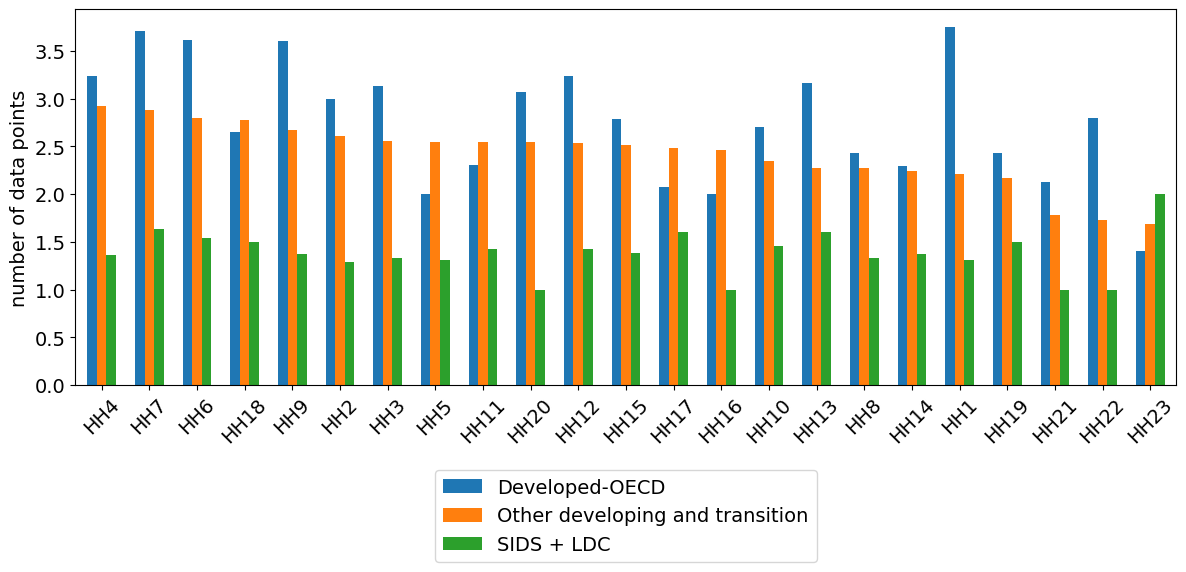

In [ ]:
rename_dict = {
    'HH1_5y': 'HH1','HH2_5y': 'HH2','HH3_5y': 'HH3','HH4_5y': 'HH4','HH5_5y': 'HH5',
    'HH6_5y': 'HH6','HH7_5y': 'HH7','HH8_5y': 'HH8','HH9_5y': 'HH9','HH10_5y': 'HH10',
    'HH11_5y': 'HH11','HH12_5y': 'HH12','HH13_5y': 'HH13','HH14_5y': 'HH14','HH15_5y': 'HH15',
    'HH16_5y': 'HH16','HH17_5y': 'HH17','HH18_5y': 'HH18','HH19_5y': 'HH19','HH20_5y': 'HH20',
    'HH21_5y': 'HH21','HH22_5y': 'HH22','HH23_5y': 'HH23',
}

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

df[['new_group','HH1_5y','HH2_5y','HH3_5y','HH4_5y','HH5_5y','HH6_5y','HH7_5y','HH8_5y',
 'HH9_5y','HH10_5y','HH11_5y','HH12_5y','HH13_5y','HH14_5y','HH15_5y','HH16_5y',
 'HH17_5y','HH18_5y','HH19_5y','HH20_5y','HH21_5y','HH22_5y','HH23_5y']].rename(
     columns=rename_dict).groupby('new_group').mean(numeric_only=True).T.sort_values(
     by='Other developing and transition', ascending=False)[custom_order].plot(kind='bar',
                                                                              figsize=(12, 6),
                                                                              width=0.6)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

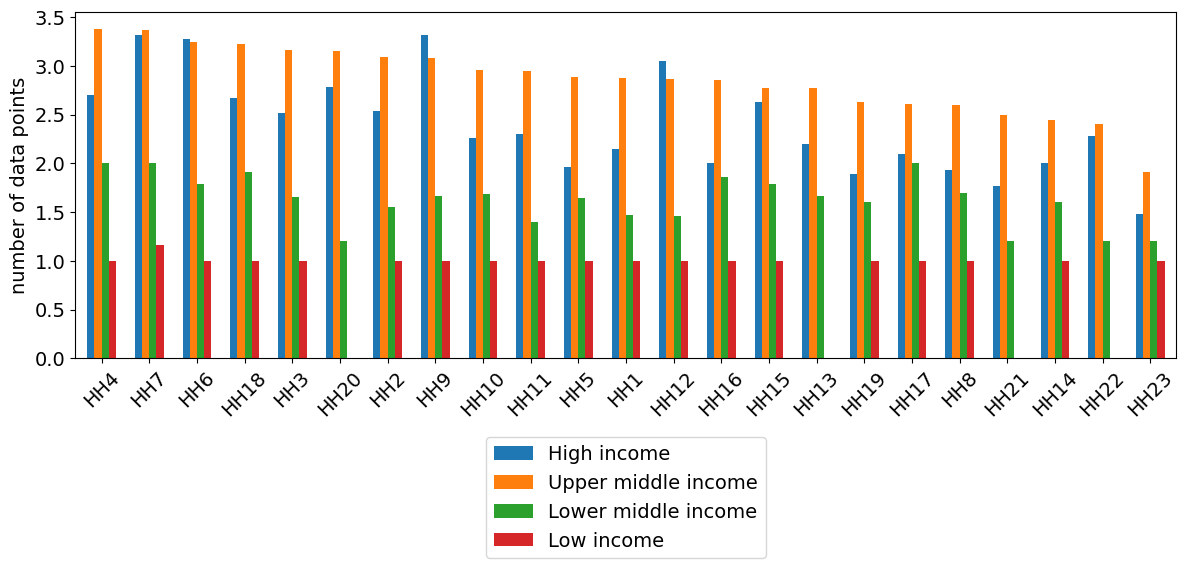

In [ ]:
rename_dict = {
    'HH1_5y': 'HH1',
    'HH2_5y': 'HH2',
    'HH3_5y': 'HH3',
    'HH4_5y': 'HH4',
    'HH5_5y': 'HH5',
    'HH6_5y': 'HH6',
    'HH7_5y': 'HH7',
    'HH8_5y': 'HH8',
    'HH9_5y': 'HH9',
    'HH10_5y': 'HH10',
    'HH11_5y': 'HH11',
    'HH12_5y': 'HH12',
    'HH13_5y': 'HH13',
    'HH14_5y': 'HH14',
    'HH15_5y': 'HH15',
    'HH16_5y': 'HH16',
    'HH17_5y': 'HH17',
    'HH18_5y': 'HH18',
    'HH19_5y': 'HH19',
    'HH20_5y': 'HH20',
    'HH21_5y': 'HH21',
    'HH22_5y': 'HH22',
    'HH23_5y': 'HH23',
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

df[['wb_income','HH1_5y','HH2_5y','HH3_5y','HH4_5y',
 'HH5_5y','HH6_5y','HH7_5y','HH8_5y',
 'HH9_5y','HH10_5y','HH11_5y','HH12_5y',
 'HH13_5y','HH14_5y','HH15_5y','HH16_5y',
 'HH17_5y','HH18_5y','HH19_5y','HH20_5y',
 'HH21_5y','HH22_5y','HH23_5y']].rename(
     columns=rename_dict).groupby('wb_income').mean(numeric_only=True).T.sort_values(
     by='Upper middle income', ascending=False)[custom_order].plot(kind='bar',
                                                                              figsize=(12, 6),
                                                                              width=0.6)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

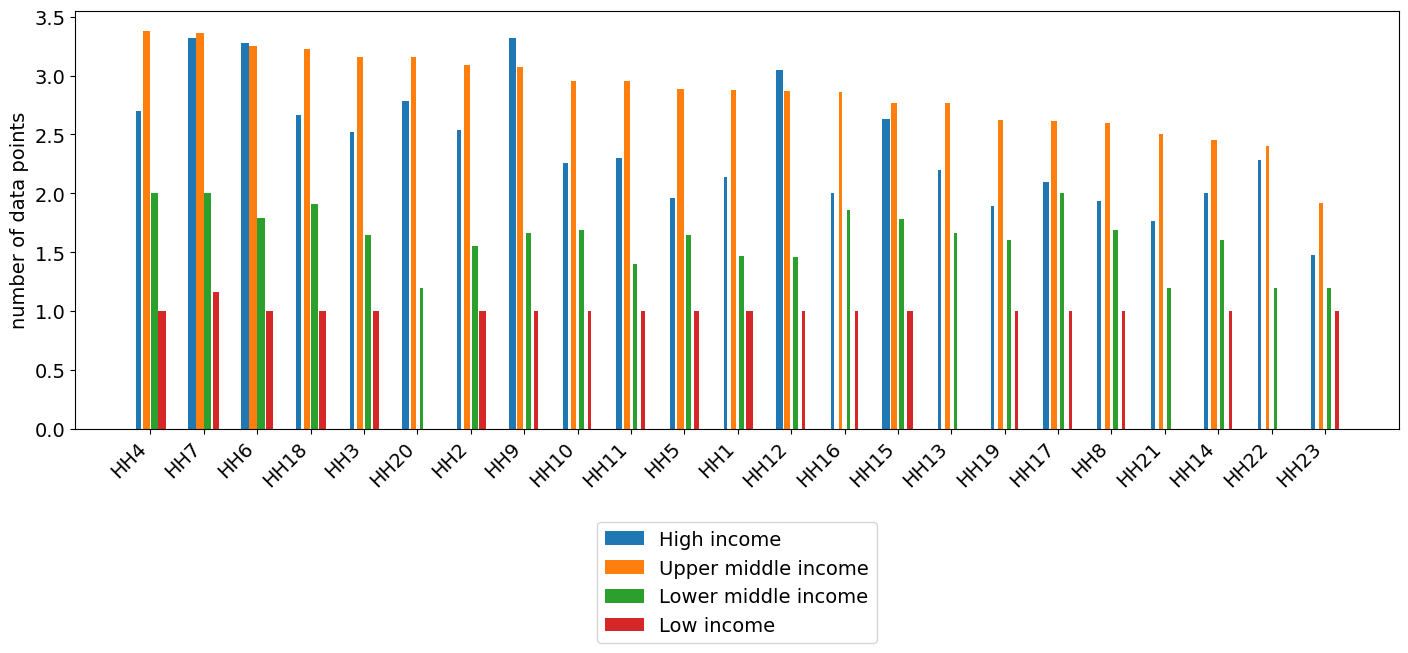

In [ ]:
from matplotlib.patches import Patch

rename_dict = {
    'HH1_5y': 'HH1','HH2_5y': 'HH2','HH3_5y': 'HH3','HH4_5y': 'HH4','HH5_5y': 'HH5','HH6_5y': 'HH6','HH7_5y': 'HH7',
    'HH8_5y': 'HH8','HH9_5y': 'HH9','HH10_5y': 'HH10','HH11_5y': 'HH11','HH12_5y': 'HH12','HH13_5y': 'HH13','HH14_5y': 'HH14',
    'HH15_5y': 'HH15','HH16_5y': 'HH16','HH17_5y': 'HH17','HH18_5y': 'HH18','HH19_5y': 'HH19','HH20_5y': 'HH20','HH21_5y': 'HH21',
    'HH22_5y': 'HH22','HH23_5y': 'HH23',
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

subset = df[['wb_income','HH1_5y','HH2_5y','HH3_5y','HH4_5y',
 'HH5_5y','HH6_5y','HH7_5y','HH8_5y',
 'HH9_5y','HH10_5y','HH11_5y','HH12_5y',
 'HH13_5y','HH14_5y','HH15_5y','HH16_5y',
 'HH17_5y','HH18_5y','HH19_5y','HH20_5y',
 'HH21_5y','HH22_5y','HH23_5y']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('wb_income').mean(numeric_only=True).T
counts = subset.groupby('wb_income').count().T

# Sort by Upper middle income
means_sorted = means.sort_values(by='Upper middle income', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each income group separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

# Store colors for legend
colors = [f'C{i}' for i in range(len(custom_order))]

for i, income_group in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[income_group].max()

    # Normalize within the group
    width_factors = counts_sorted[income_group] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[income_group].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=colors[i]
        )

        # Add text label on top of bar
        #count = int(counts_sorted[income_group].iloc[j])
        #if count > 0:
           # ax.text(
               # bar_x,
               # value,
               # f'n={count}',
               # ha='center',
               # va='bottom',
               # fontsize=9,
               # rotation=0
            #)

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=colors[i], label=income_group)
                  for i, income_group in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()

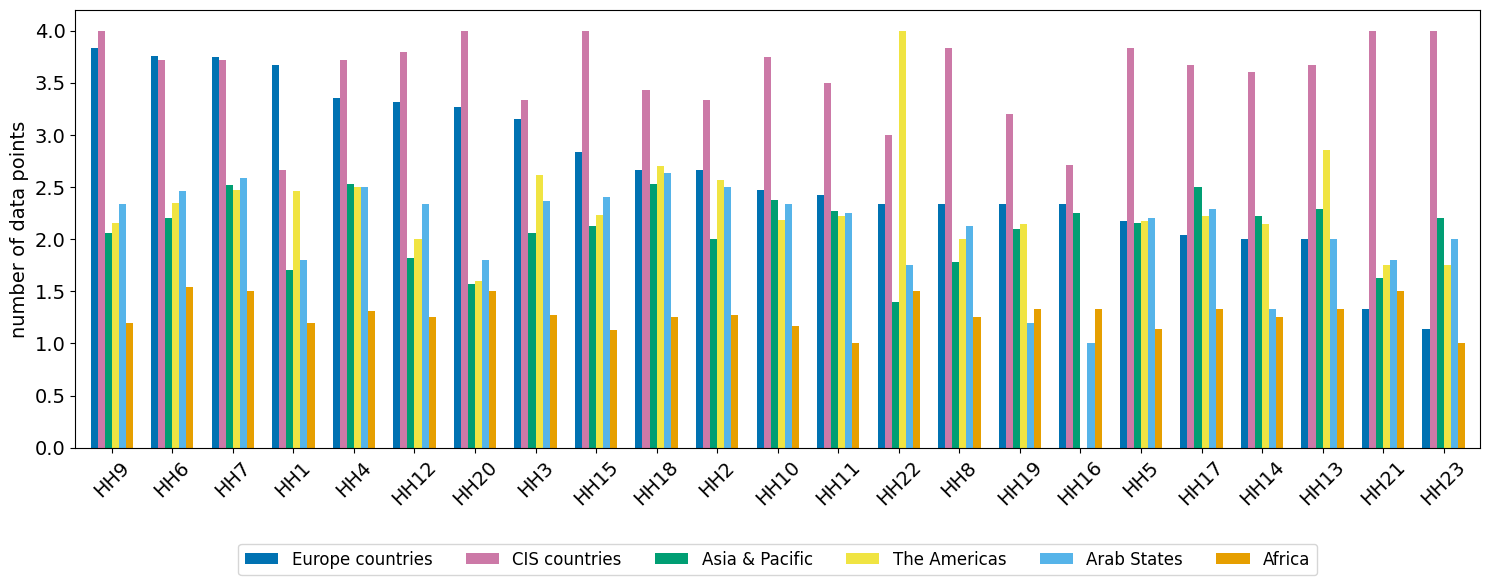

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
 'HH1_5y': 'HH1',
 'HH2_5y': 'HH2',
 'HH3_5y': 'HH3',
 'HH4_5y': 'HH4',
 'HH5_5y': 'HH5',
 'HH6_5y': 'HH6',
 'HH7_5y': 'HH7',
 'HH8_5y': 'HH8',
 'HH9_5y': 'HH9',
 'HH10_5y': 'HH10',
 'HH11_5y': 'HH11',
 'HH12_5y': 'HH12',
 'HH13_5y': 'HH13',
 'HH14_5y': 'HH14',
 'HH15_5y': 'HH15',
 'HH16_5y': 'HH16',
 'HH17_5y': 'HH17',
 'HH18_5y': 'HH18',
 'HH19_5y': 'HH19',
 'HH20_5y': 'HH20',
 'HH21_5y': 'HH21',
 'HH22_5y': 'HH22',
 'HH23_5y': 'HH23',
}

df[['regionname','HH1_5y','HH2_5y','HH3_5y','HH4_5y',
 'HH5_5y','HH6_5y','HH7_5y','HH8_5y',
 'HH9_5y','HH10_5y','HH11_5y','HH12_5y',
 'HH13_5y','HH14_5y','HH15_5y','HH16_5y',
 'HH17_5y','HH18_5y','HH19_5y','HH20_5y',
 'HH21_5y','HH22_5y','HH23_5y']].rename(
     columns=rename_dict).groupby('regionname').mean(numeric_only=True).reindex(custom_order).T.sort_values(by='Europe countries', ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

## Apply a transformation so that we group indicators by type that is relevant for assessing capacity

In [ ]:
df[hh_cols_].columns

Index(['HH1_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y', 'HH13_5y', 'HH14_5y',
       'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y', 'HH19_5y', 'HH2_5y',
       'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y', 'HH3_5y', 'HH4_5y',
       'HH5_5y', 'HH6_5y', 'HH7_5y', 'HH8_5y', 'HH9_5y'],
      dtype='object')

In [ ]:
# define groups of indicators

entry_household = ['HH1', 'HH2', 'HH3', 'HH4', 'HH6']
entry_individual = ['HH5', 'HH7', 'HH10', 'HH18']
disaggregated_household = ['HH11', 'HH14']
disaggregated_individual = ['HH8', 'HH9', 'HH12', 'HH13', 'HH15', 'HH17', 'HH19', 'HH20', 'HH21', 'HH22' 'HH23']
expenditure = ['HH16']

HH1_5y shows how many times the data was available in the 5 year period. HH2_5y shows how many times data was available for this indicator in the 5 year period. So I take the maximum of the two to say how many times data was available for the group in the last 5 years.

In [ ]:
groups = {
    'entry_household': entry_household,
    'entry_individual': entry_individual,
    'disaggregated_household': disaggregated_household,
    'disaggregated_individual': disaggregated_individual,
    'expenditure': expenditure
}

for new_col, base_cols in groups.items():
    matching_cols = [f"{b}_5y" for b in base_cols if f"{b}_5y" in df.columns]
    df[f"{new_col}_5y"] = df[matching_cols].max(axis=1)


In [ ]:
df.entry_household_5y.describe()

,entry_household_5y
count,127.000000
mean,2.763780
std,1.433481
min,1.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,5.000000


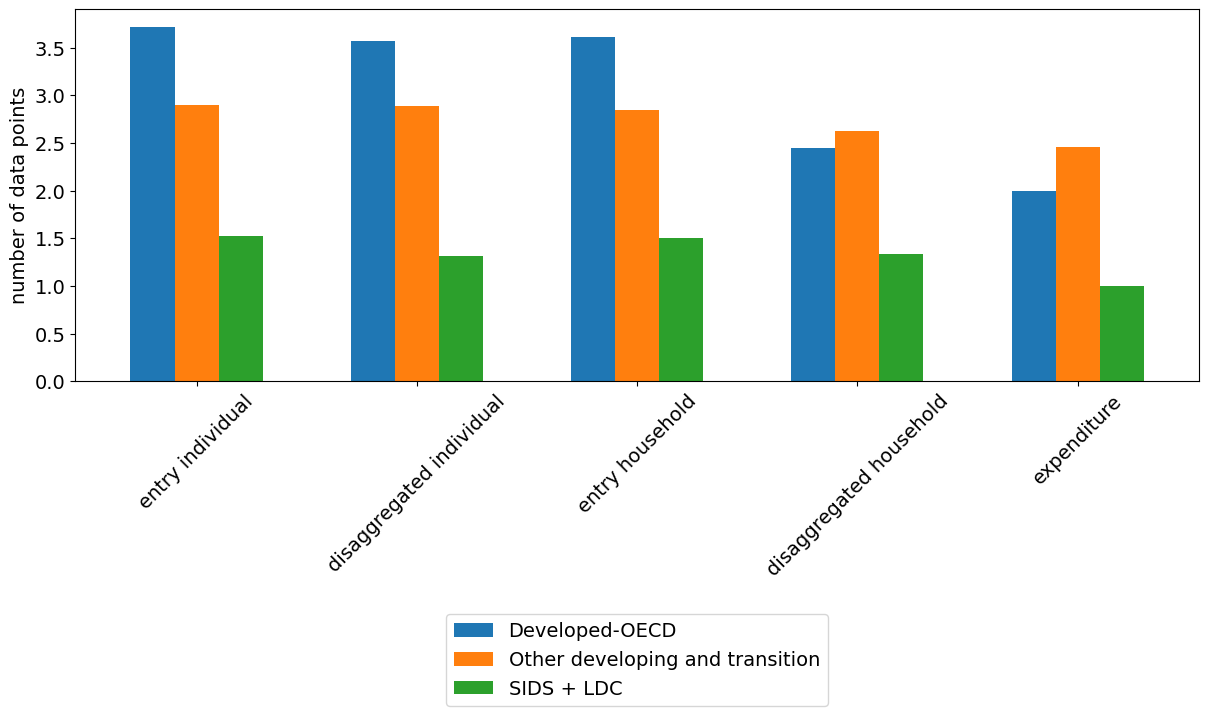

In [ ]:
rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

df[['new_group', 'entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']].rename(
     columns=rename_dict).groupby('new_group').mean(numeric_only=True).T.sort_values(
     by='Other developing and transition', ascending=False)[custom_order].plot(kind='bar',
                                                                              figsize=(12, 6),
                                                                              width=0.6)
#plt.title('Average number of data points per group of indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.7)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

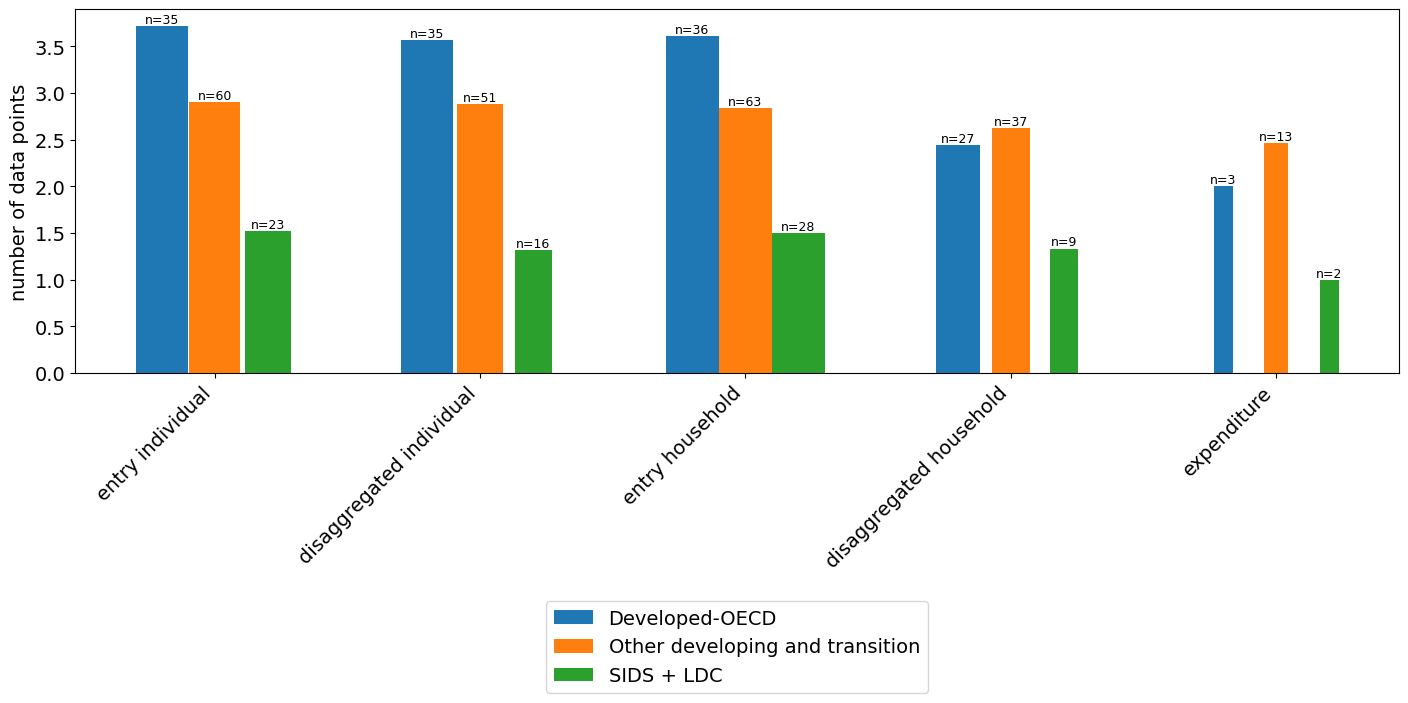

In [ ]:
from matplotlib.patches import Patch

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

subset = df[['new_group','entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('new_group').mean(numeric_only=True).T
counts = subset.groupby('new_group').count().T

# Sort by Upper middle income
means_sorted = means.sort_values(by='Other developing and transition', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each income group separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

# Store colors for legend
colors = [f'C{i}' for i in range(len(custom_order))]

for i, income_group in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[income_group].max()

    # Normalize within the group
    width_factors = counts_sorted[income_group] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[income_group].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[income_group].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=colors[i], label=income_group)
                  for i, income_group in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()

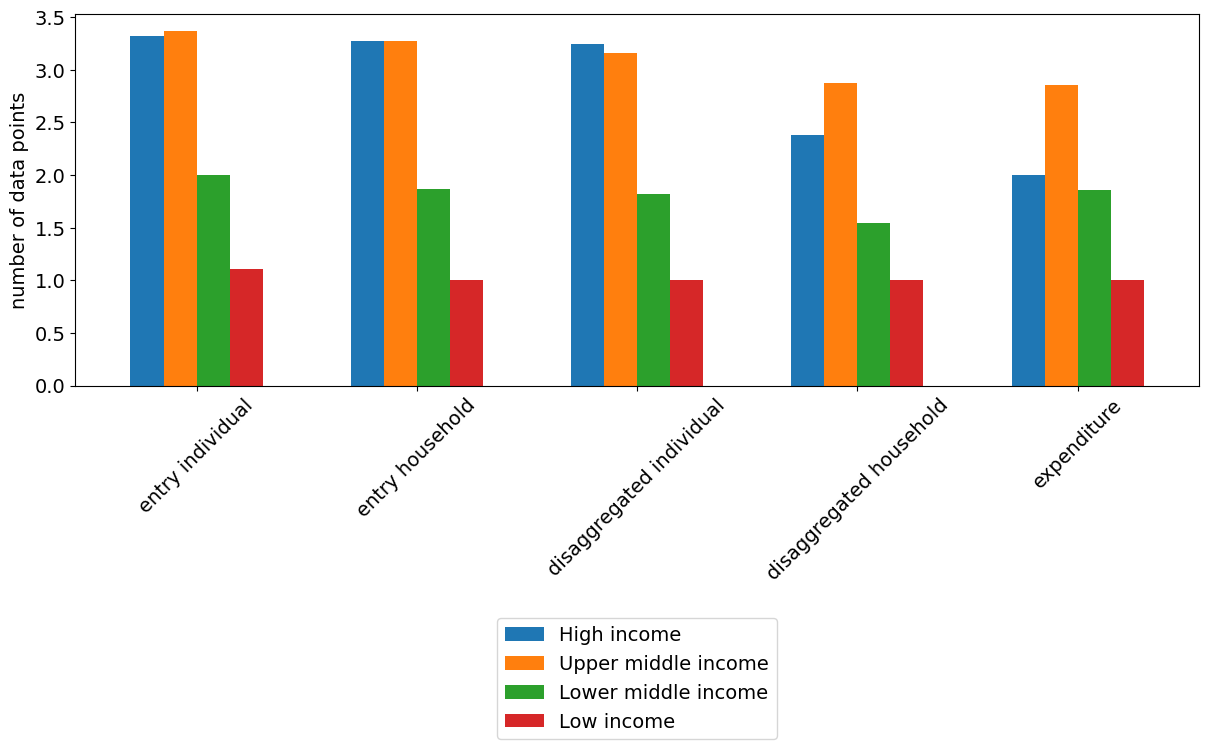

In [ ]:

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

df[['wb_income','entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y'
 ]].rename(columns=rename_dict).groupby('wb_income').mean(numeric_only=True).T.sort_values(
     by='Upper middle income', ascending=False)[custom_order].plot(kind='bar',
                                                figsize=(12, 6),
                                                width=0.6)
#plt.title('Average number of data points per group of indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1) # places legend bottom

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.7)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

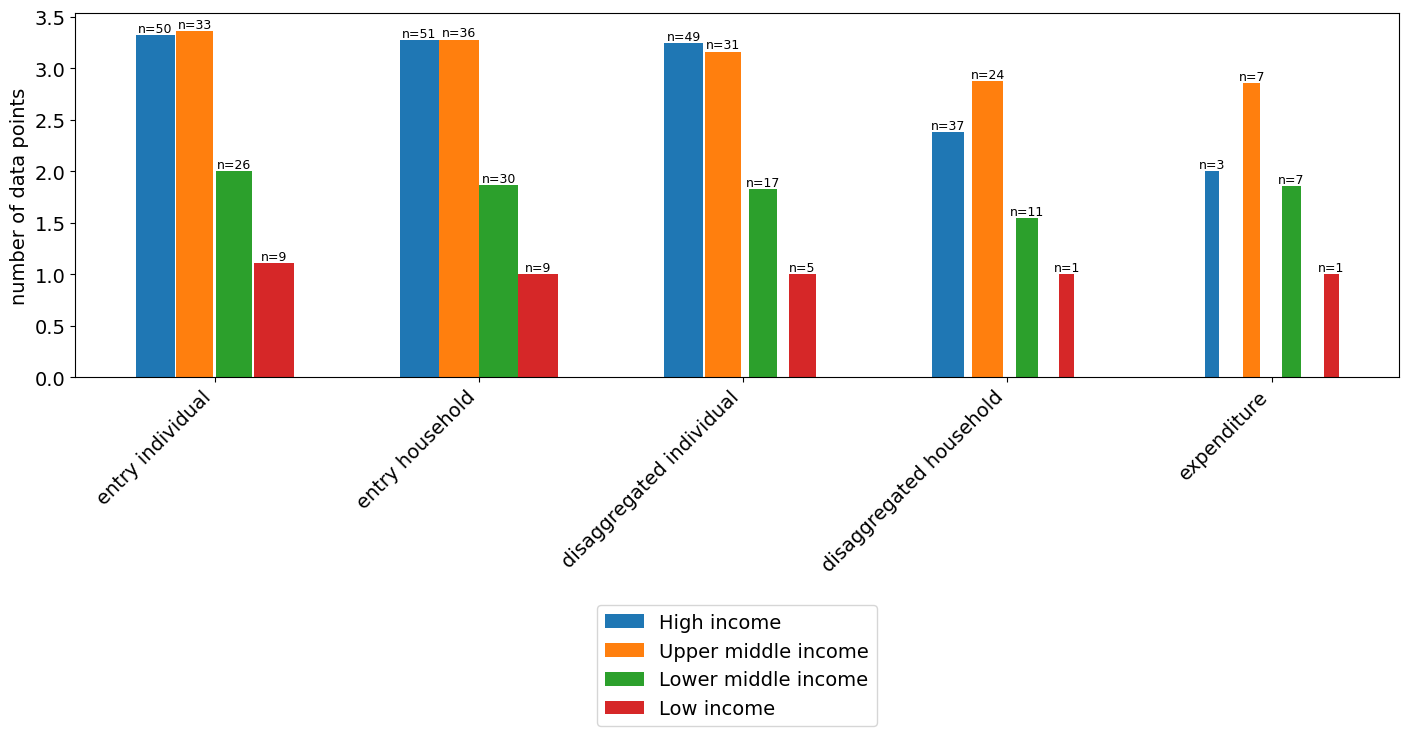

In [ ]:
from matplotlib.patches import Patch

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

subset = df[['wb_income','entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('wb_income').mean(numeric_only=True).T
counts = subset.groupby('wb_income').count().T

# Sort by Upper middle income
means_sorted = means.sort_values(by='Upper middle income', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each income group separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

# Store colors for legend
colors = [f'C{i}' for i in range(len(custom_order))]

for i, income_group in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[income_group].max()

    # Normalize within the group
    width_factors = counts_sorted[income_group] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[income_group].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[income_group].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=colors[i], label=income_group)
                  for i, income_group in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()

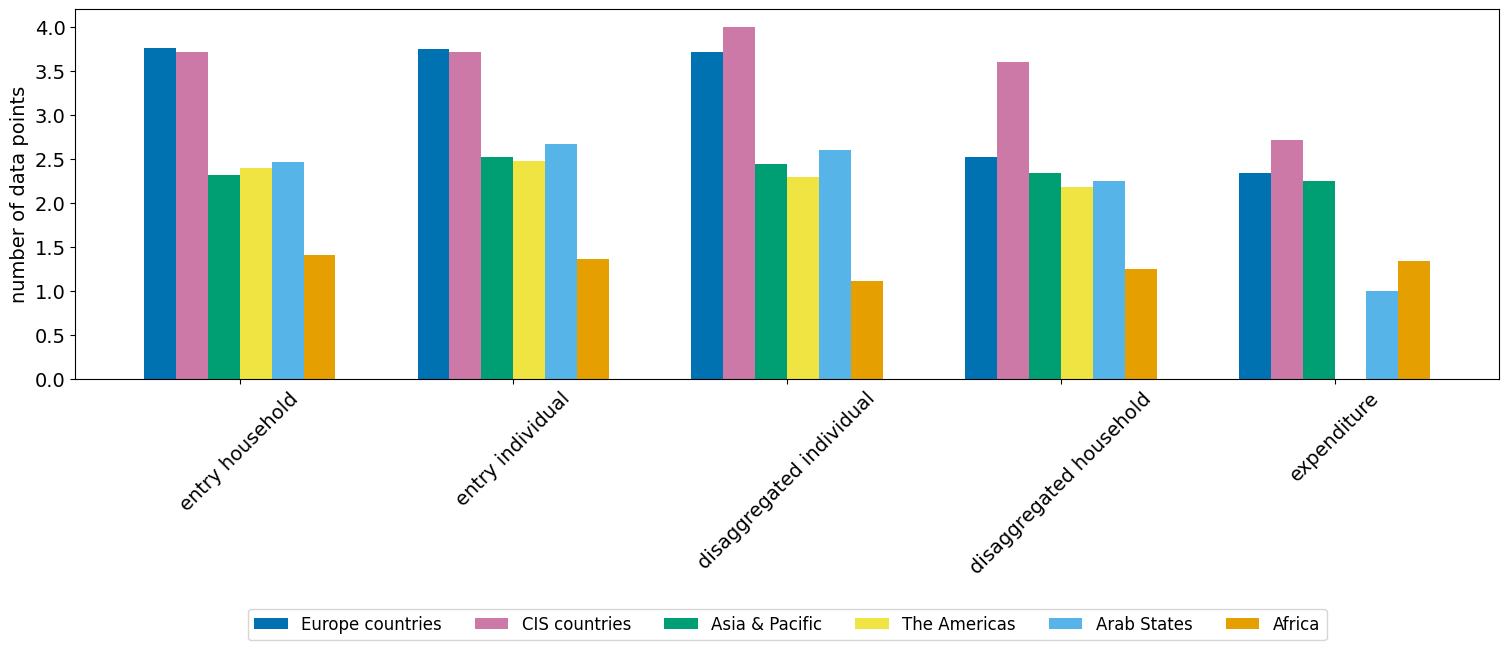

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'#,  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

df[['regionname','entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']].rename(
     columns=rename_dict).groupby('regionname').mean(numeric_only=True).reindex(custom_order).T.sort_values(
     by='Europe countries', ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)

#plt.title('Average number of data points per group of indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.7)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

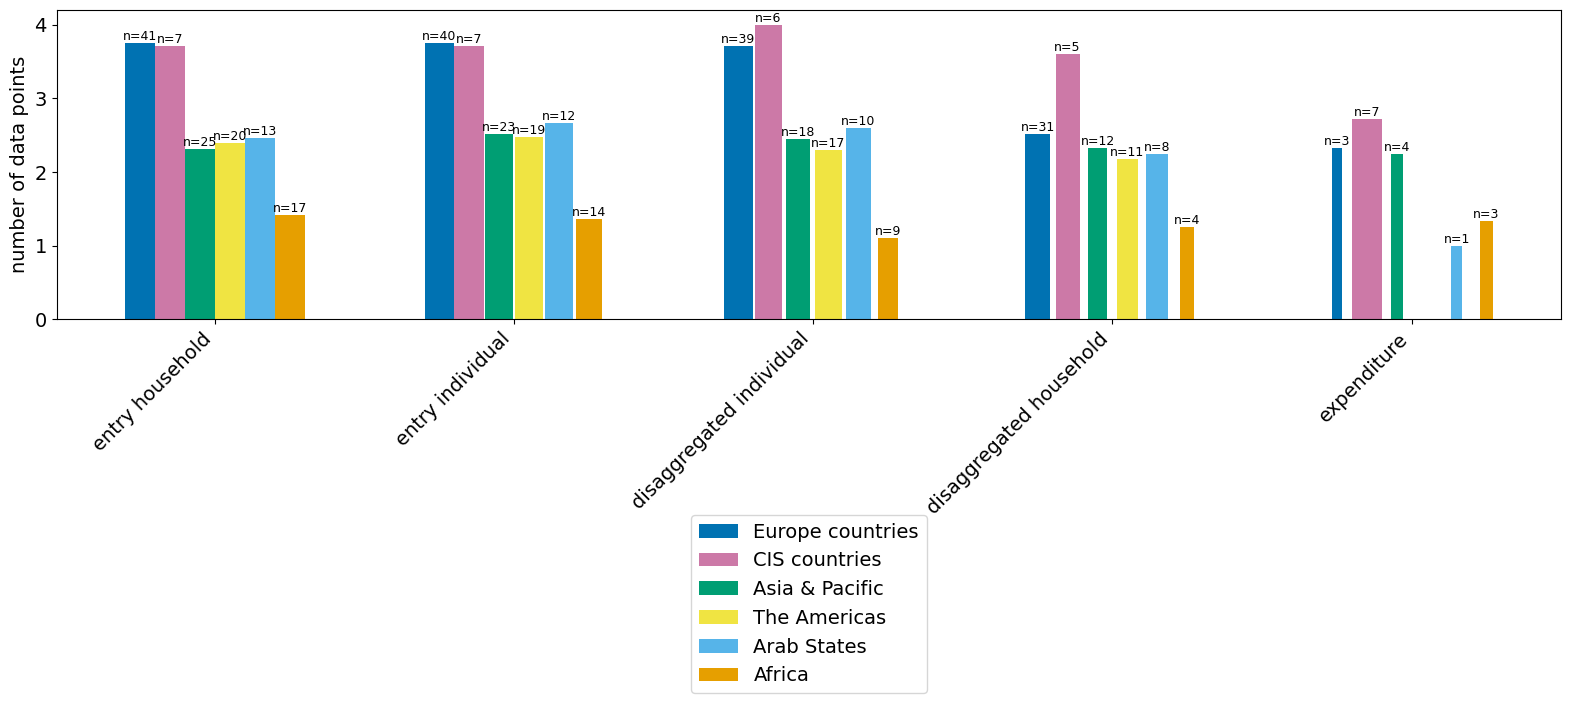

In [ ]:
rename_dict = {
'entry_household_5y': 'entry household',
'entry_individual_5y': 'entry individual',
'disaggregated_household_5y': 'disaggregated household',
'disaggregated_individual_5y': 'disaggregated individual',
'expenditure_5y': 'expenditure',
}
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
custom_colors = [
'#0072B2',  # Blue
'#CC79A7',  # Pink/Purple
'#009E73',  # Green
'#F0E442',  # Yellow
'#56B4E9',  # Light Blue
'#E69F00'   # Orange
]

subset = df[['regionname','entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('regionname').mean(numeric_only=True).T
counts = subset.groupby('regionname').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Europe countries', ascending=False)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(16, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0
            )

ax.set_xlabel('', fontsize=14)
ax.set_ylabel('number of data points', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=14, ha='right')
ax.tick_params(axis='y', labelsize=14)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)]

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()

# DOT PLOTS - assess how many countries have data by group

In [ ]:
df[['shortname', 'regionname','HH4_5y']][(df.regionname=='CIS countries')]

,shortname,regionname,HH4_5y
6,Armenia,CIS countries,4.0
10,Azerbaijan,CIS countries,4.0
15,Belarus,CIS countries,4.0
87,Kazakhstan,CIS countries,5.0
93,Kyrgyzstan,CIS countries,1.0
143,Russian Federation,CIS countries,4.0
168,Tajikistan,CIS countries,NaN
177,Turkmenistan,CIS countries,NaN
187,Uzbekistan,CIS countries,4.0


In [ ]:
hh_cols = [f'HH{i}_5y' for i in range(1, 24)]

# Count non-NaN values by region for each indicator
country_counts_by_region = df.groupby('regionname')[hh_cols].apply(lambda x: x.notna().sum())

country_counts_by_region

,HH1_5y,HH2_5y,HH3_5y,HH4_5y,HH5_5y,HH6_5y,HH7_5y,HH8_5y,HH9_5y,HH10_5y,...,HH14_5y,HH15_5y,HH16_5y,HH17_5y,HH18_5y,HH19_5y,HH20_5y,HH21_5y,HH22_5y,HH23_5y
regionname,,,,,,,,,,,,,,,,,,,,,
Africa,10,11,11,13,7,13,10,4,5,6,...,4,8,3,3,12,3,2,2,2,3
Arab States,5,6,11,12,10,13,12,8,9,9,...,6,10,1,7,11,5,5,5,4,4
Asia & Pacific,10,13,18,19,13,25,23,14,16,16,...,9,16,4,10,17,10,7,8,5,5
CIS countries,3,6,6,7,6,7,7,6,5,4,...,5,5,7,3,7,5,2,2,2,2
Europe countries,3,9,13,17,17,41,40,3,37,19,...,12,37,3,25,18,6,34,3,3,21
Other Economies,0,0,2,3,1,3,3,1,2,1,...,0,2,0,0,2,0,0,0,0,0
The Americas,13,14,13,18,17,20,19,13,13,16,...,7,13,0,9,10,7,5,4,1,4


In [ ]:
country_counts_long = df.groupby('regionname')[hh_cols].apply(lambda x: x.notna().sum()).T.reset_index().melt(
    id_vars='index',
    var_name='regionname',
    value_name='Number_of_Countries'
).rename(columns={'index': 'Indicator'})

country_counts_long

,Indicator,regionname,Number_of_Countries
0,HH1_5y,Africa,10
1,HH2_5y,Africa,11
2,HH3_5y,Africa,11
3,HH4_5y,Africa,13
4,HH5_5y,Africa,7
...,...,...,...
156,HH19_5y,The Americas,7
157,HH20_5y,The Americas,5
158,HH21_5y,The Americas,4
159,HH22_5y,The Americas,1


In [ ]:
country_counts_long= country_counts_long[country_counts_long.regionname!='Other Economies']

In [ ]:
country_counts_long.regionname.unique()

array(['Africa', 'Arab States', 'Asia & Pacific', 'CIS countries',
       'Europe countries', 'The Americas'], dtype=object)

In [ ]:
import plotly.express as px


# Define custom order and colors
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'   # Orange
]

# Create a color mapping dict
color_map = dict(zip(custom_order, custom_colors))


country_counts_long

# Create the scatter plot with custom order and colors
fig = px.scatter(
    country_counts_long,
    y="Indicator",
    x="Number_of_Countries",
    color="regionname",
    symbol="regionname",
    category_orders={"regionname": custom_order},  # enforce order
    color_discrete_map=color_map                   # enforce colors
)

# Rename y-axis tick labels
fig.update_yaxes(
    ticktext=['HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'HH6','HH7', 'HH8', 'HH9', 'HH10', 'HH11', 'HH12',
       'HH13', 'HH14', 'HH15', 'HH16', 'HH17', 'HH18','HH19', 'HH20', 'HH21', 'HH22', 'HH23'],
    tickvals=['HH1_5y', 'HH2_5y', 'HH3_5y', 'HH4_5y', 'HH5_5y', 'HH6_5y','HH7_5y', 'HH8_5y', 'HH9_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y',
       'HH13_5y', 'HH14_5y', 'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y','HH19_5y', 'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y']
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    width=1500,   # Set width in pixels
    height=700,   # Set height in pixels
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


In [ ]:
hh_cols = [f'HH{i}_5y' for i in range(1, 24)]
country_counts_long = df.groupby('wb_income')[hh_cols].apply(lambda x: x.notna().sum()).T.reset_index().melt(
    id_vars='index',
    var_name='wb_income',
    value_name='Number_of_Countries'
).rename(columns={'index': 'Indicator'})

country_counts_long

,Indicator,wb_income,Number_of_Countries
0,HH1_5y,High income,7
1,HH2_5y,High income,13
2,HH3_5y,High income,23
3,HH4_5y,High income,30
4,HH5_5y,High income,28
...,...,...,...
87,HH19_5y,Upper middle income,16
88,HH20_5y,Upper middle income,13
89,HH21_5y,Upper middle income,6
90,HH22_5y,Upper middle income,5


In [ ]:
import plotly.express as px


# Define custom order and colors
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728'  # Red
]

# Create a color mapping dict
color_map = dict(zip(custom_order, custom_colors))


country_counts_long

# Create the scatter plot with custom order and colors
fig = px.scatter(
    country_counts_long,
    y="Indicator",
    x="Number_of_Countries",
    color="wb_income",
    symbol="wb_income",
    category_orders={"wb_income": custom_order},  # enforce order
    color_discrete_map=color_map                   # enforce colors
)

# Rename y-axis tick labels
fig.update_yaxes(
    ticktext=['HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'HH6','HH7', 'HH8', 'HH9', 'HH10', 'HH11', 'HH12',
       'HH13', 'HH14', 'HH15', 'HH16', 'HH17', 'HH18','HH19', 'HH20', 'HH21', 'HH22', 'HH23'],
    tickvals=['HH1_5y', 'HH2_5y', 'HH3_5y', 'HH4_5y', 'HH5_5y', 'HH6_5y','HH7_5y', 'HH8_5y', 'HH9_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y',
       'HH13_5y', 'HH14_5y', 'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y','HH19_5y', 'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y']
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    width=1500,   # Set width in pixels
    height=700,   # Set height in pixels
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


In [ ]:
hh_cols = [f'HH{i}_5y' for i in range(1, 24)]
country_counts_long = df.groupby('new_group')[hh_cols].apply(lambda x: x.notna().sum()).T.reset_index().melt(
    id_vars='index',
    var_name='new_group',
    value_name='Number_of_Countries'
).rename(columns={'index': 'Indicator'})

country_counts_long

,Indicator,new_group,Number_of_Countries
0,HH1_5y,Developed-OECD,4
1,HH2_5y,Developed-OECD,9
2,HH3_5y,Developed-OECD,15
3,HH4_5y,Developed-OECD,17
4,HH5_5y,Developed-OECD,16
...,...,...,...
64,HH19_5y,SIDS + LDC,6
65,HH20_5y,SIDS + LDC,3
66,HH21_5y,SIDS + LDC,2
67,HH22_5y,SIDS + LDC,1


In [ ]:
import plotly.express as px


# Define custom order and colors
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
]

# Create a color mapping dict
color_map = dict(zip(custom_order, custom_colors))


country_counts_long

# Create the scatter plot with custom order and colors
fig = px.scatter(
    country_counts_long,
    y="Indicator",
    x="Number_of_Countries",
    color="new_group",
    symbol="new_group",
    category_orders={"new_group": custom_order},  # enforce order
    color_discrete_map=color_map                   # enforce colors
)

# Rename y-axis tick labels
fig.update_yaxes(
    ticktext=['HH1', 'HH2', 'HH3', 'HH4', 'HH5', 'HH6','HH7', 'HH8', 'HH9', 'HH10', 'HH11', 'HH12',
       'HH13', 'HH14', 'HH15', 'HH16', 'HH17', 'HH18','HH19', 'HH20', 'HH21', 'HH22', 'HH23'],
    tickvals=['HH1_5y', 'HH2_5y', 'HH3_5y', 'HH4_5y', 'HH5_5y', 'HH6_5y','HH7_5y', 'HH8_5y', 'HH9_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y',
       'HH13_5y', 'HH14_5y', 'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y','HH19_5y', 'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y']
)

# Optional: update marker size
fig.update_traces(marker_size=15)

# Remove gray background and grid lines
fig.update_layout(
    xaxis_title="Number of Countries",
    yaxis_title=" ",
    width=1500,   # Set width in pixels
    height=700,   # Set height in pixels
    plot_bgcolor='#F5F5F5',  # white background
    paper_bgcolor='white', # white surrounding background
    xaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),  # remove x-axis grid lines
    yaxis=dict(showgrid=False, title_font=dict(size=18), tickfont=dict(size=18)),   # remove y-axis grid lines
    legend=dict(font=dict(size=18))
)

fig.show()


## From metadata  -- > read what was the "data source"

In [ ]:
file_path = '/content/HH Metadata_2015+.xlsx'

df_meta = pd.read_excel(file_path, sheet_name='Sheet 1', header=1)

 The column Code in this dataset includes the key to what kind of metadata can be consulted. For example we will use HHM Survey Type.

In [ ]:
df_meta.sample(5)

,DataYear,CountryID,ShortName,RegionName,CountryType,Code,CodeDesc,ValueText
993,2016,203,Sweden,Europe countries,High income,HHMNameOrig,Name of survey in original language,IT bland individer
14643,2020,76,Estonia,Europe countries,High income,HHMReferencePeriod,Reference period,last 3 months
12878,2021,138,Lithuania,Europe countries,High income,HHMWeightingMethods,Weighting methods,Sample weights were used to calculate estimate...
3881,2019,137,Lesotho,Africa,Lower middle income,HHMSurveyType,Type of Survey (survey vehicle),Labour force survey
13621,2015,120,Japan,Asia & Pacific,High income,HHMNonSamplingError,Non-sampling error,HOUSEHOLDS:0.8%\nPOPULATION:0.5%


In [ ]:
df_meta.Code.unique()

array(['HHMName', 'HHMNameOrig', 'HHMOrganization', 'HHMContactPerson',
       'HHMYear', 'HHMSurveyType', 'HHMCollectionTechnique',
       'HHMSamplingFrame', 'HHMSampleDesign', 'HHMSamplingUnit',
       'HHMSampleSize', 'HHMSampleSizePost', 'HHMScopeHousehold',
       'HHMScopeIndividual', 'HHMFrequency', 'HHMResponseRate',
       'HHMNonRespTreatment', 'HHMWeightingMethods', 'HHMStandardError',
       'HHMNonSamplingError', 'HHMReferencePeriod', 'HHMLegalBasis',
       'HHMURL', 'HHMPersonSelection', 'HHAgeScope'], dtype=object)

For the purpose of the analysis here, we need to trim the metadata dataframe -- include only data for the last 5 years - i.e. when the reference year falls in the 2019-2023 time interval (datayear=2023 for 2024 data) AND only read data about HHM Survey Type to extract information about the source.

In the future the metadata could be further explored beyond what is done here.

In [ ]:
df_meta = df_meta[(df_meta.DataYear >= 2020) & (df_meta.Code == 'HHMSurveyType')]

In [ ]:
# checking what kind of data is reported under this column in the last 5 years (2020-2024)
df_meta.ValueText[(df_meta.Code == 'HHMSurveyType') & (df_meta.DataYear >= 2020)].unique()


array(['Household Survey', 'ICT survey (stand-alone ICT survey)',
       'Other household survey (multi-purpose survey)', nan,
       'ICT survey (stand-alone ICT survey) ',
       'Budget or expenditure household survey', 'Labour force survey',
       'Living condition survey', '-',
       'annual survey, based on a sample of individuals, conducted since 2002',
       'Survey technique was face – to – face interview, in an arranged date of visit in advance.',
       'Projected based on 2019 Population census',
       'Other source, no survey', 'Census'], dtype=object)

Determine what was the most frequent type of data source in the last 5 years (2020-2024)

For this I will encode the data points as "ICT survey"=3, "household survey"=2, "other survey"=1, "other source"=0 (this last one included nan)

In [ ]:
# clean any trailing white space
df_meta['ValueText'] = df_meta['ValueText'].str.strip()

In [ ]:
# Define sets of values
household_survey_values = {
    'Living condition survey',
    'Other household survey (multi-purpose survey)',
    'Labour force survey',
    'household survey',
    'HOUSEHOLD SURVEY',
    'Household Survey',
    'Household sample survey',
    'Household health survey',
    'Other household survey (multi-purpose survey)',
    'Household Telephone Survey',
    '1.Face to face interview to fill out the general information of samples household members. \r\n2. For the households with at least one internet user, the questionnaire was left to the household for answering the ICT questions by the internet user(s).',
    'Household and Individuals Survey',
    'ENQUETE AUPRES DES MENAGES',
    'Budget or expenditure household survey',
    'Enquête auprès des ménages',
    'Encuesta a hogares (muestra), 2019',
    'Household Social Consumption on Education in India',
    'Social Consumption - Education : Household Consumption Expenditure Survey\r\n\r\nAISHE: Survey on Higher Education'
}

ict_survey_values = {
    'ICT survey (stand-alone ICT survey)'
}

other_survey_values = {
    "Autre type d'enquête",
    'CONTINUOS SURVEY',
    'ENCUESTA CONTINUA',
    'Continua',
    'Sample survey',
    "Survey with ICT module.",
    'annual survey, based on a sample of individuals, conducted since 2002',
    'Adhoc module on ICT use by households and individuals',
    'full coverage', 'Politemática',
    'Encuesta por muestreo'
}

other_source_values = {
    'Census',
    'Estimates by DOSM',
    'No Household Survey was carried out in 2015',
    'Survey technique was face – to – face interview, in an arranged date of visit in advance.',
    'Other source, no survey',
    'Estimation Institut National de la Statistique',
    'NaN',
    'nan',
    '-',
    'Personal interview (face-to-face; other technique)',
    'No survey conducted',
    'Estimates',
    'Population Projection',
    'Face to Face',
    'Face-to-face interview',
    'Projected based on 2019 Population census',
    'Face-to-face interviews using physical questionnaires with  that are scanned and processed.'
}

# Create new binary columns
df_meta['hh_survey'] = df_meta['ValueText'].isin(household_survey_values).astype(int)
df_meta['ict_survey'] = df_meta['ValueText'].isin(ict_survey_values).astype(int)
df_meta['other_survey'] = df_meta['ValueText'].isin(other_survey_values).astype(int)
df_meta['other_source'] = df_meta['ValueText'].isin(other_source_values).astype(int)

In [ ]:
df_meta[df_meta.Code == 'HHMSurveyType'].sample(5)

,DataYear,CountryID,ShortName,RegionName,CountryType,Code,CodeDesc,ValueText,hh_survey,ict_survey,other_survey,other_source
4193,2022,124,Jordan,Arab States,Upper middle income,HHMSurveyType,Type of Survey (survey vehicle),Labour force survey,1,0,0,0
4305,2023,245,Uzbekistan,CIS countries,Lower middle income,HHMSurveyType,Type of Survey (survey vehicle),ICT survey (stand-alone ICT survey),0,1,0,0
4304,2023,244,United States,The Americas,High income,HHMSurveyType,Type of Survey (survey vehicle),Other household survey (multi-purpose survey),1,0,0,0
4152,2022,16,Argentina,The Americas,Upper middle income,HHMSurveyType,Type of Survey (survey vehicle),Other household survey (multi-purpose survey),1,0,0,0
3972,2020,84,United Kingdom,Europe countries,High income,HHMSurveyType,Type of Survey (survey vehicle),Other household survey (multi-purpose survey),1,0,0,0


In [ ]:
#  I generate a new column that summarizes data sources - a source cannot be 2 or more of these categories at the same time
df_meta['overall_source'] = 3*df_meta['hh_survey'] + 2*df_meta['ict_survey'] + 1*df_meta['other_survey'] + 0*df_meta['other_source']

now I need to group the filetered data by country and get the mode (the most frequent value)

In [ ]:
df_mode_source = df_meta.groupby(['ShortName', 'CountryID'])['overall_source'].agg(lambda x: x.mode().iloc[0]).reset_index()
# this is the most common data source for the reported data

In [ ]:
df_mode_source['overall_source_text'] = df_mode_source['overall_source'].map({
    3: 'household survey',
    2: 'ICT survey',
    1: 'other survey',
    0: 'other source'
})

In [ ]:
df_mode_source.sample(5)

,ShortName,CountryID,overall_source,overall_source_text
120,Uruguay,242,0,other source
1,Argentina,16,3,household survey
5,Azerbaijan,25,2,ICT survey
91,Romania,200,2,ICT survey
80,Niger,166,3,household survey


In [ ]:
df_mode_source.ShortName.unique()

array(['Albania', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium',
       'Belize', 'Bhutan', 'Bolivia (Plurinational State of)',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica',
       'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', "Côte d'Ivoire",
       'Denmark', 'Dominican Rep.', 'Ecuador', 'Egypt', 'El Salvador',
       'Estonia', 'Finland', 'France', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Guatemala', 'Hong Kong, China', 'Hungary',
       'Iceland', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Korea (Rep. of)', 'Kuwait', 'Kyrgyzstan',
       'Latvia', 'Liberia', 'Lithuania', 'Luxembourg', 'Macao, China',
       'Malawi', 'Malaysia', 'Maldives', 'Mal

In [ ]:
df_mode_source[df_mode_source.ShortName=='Mauritius']

,ShortName,CountryID,overall_source,overall_source_text
71,Mauritius,142,3,household survey


OK, we'll add this to the main df so that it's available for further analysis

In [ ]:
df.columns

Index(['country', 'HH1_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y', 'HH13_5y',
       'HH14_5y', 'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y', 'HH19_5y',
       'HH2_5y', 'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y', 'HH3_5y',
       'HH4_5y', 'HH5_5y', 'HH6_5y', 'HH7_5y', 'HH8_5y', 'HH9_5y', 'shortname',
       'regionname', 'countrytype', 'itumember', 'ldc', 'lldc', 'sids',
       'm49region', 'm49subregion', 'ison3code', 'language6', 'wb_income',
       'itu_admin_region', 'umc_event_region', 'oecd_member', 'latest_year',
       'number_of_years_with_available_data', 'iso3', 'hh1', 'hh2', 'hh3',
       'hh4', 'hh5', 'hh6', 'hh7', 'hh8', 'hh9', 'hh10', 'hh11', 'hh12',
       'hh13', 'hh14', 'hh15', 'hh16', 'hh17', 'hh18', 'hh19', 'hh20', 'hh21',
       'hh22', 'hh23', 'household_composition', 'urban_rural', 'gender', 'age',
       'age__gender', 'level_of_education', 'level_of_education__gender',
       'labour_force_status', 'occupation', 'new_group', 'entry_household_5y',
       'entry_indivi

In [ ]:
# Left join
df = df.merge(
    df_mode_source[['ShortName', 'overall_source']],
    how='left',
    left_on='country',
    right_on='ShortName'
)

In [ ]:
# fill NAs with 0 Here we have to make this assumption that if no source is provided but data is available then the source is "other source"
df['overall_source'] = df['overall_source'].fillna(0)


In [ ]:
# re-create the text description
df['overall_source_text'] = df['overall_source'].map({
    3: 'household survey',
    2: 'ICT survey',
    1: 'other survey',
    0: 'other source'
})

In [ ]:
df[['overall_source_text', 'shortname', 'ison3code']].sample(5)

,overall_source_text,shortname,ison3code
175,ICT survey,Trinidad and Tobago,780.0
179,other source,Tuvalu,798.0
19,other source,Bermuda,60.0
165,ICT survey,Sweden,752.0
99,ICT survey,Lithuania,440.0


In [ ]:
df_meta.DataYear.unique()

array([2020, 2021, 2022, 2023, 2024])

In [ ]:
df_most_recent_source = df_meta[df_meta['DataYear'] == df_meta.groupby('ShortName')['DataYear'].transform('max')]

In [ ]:
# from here on determining data source used in the last year available
df_most_recent_source[['ValueText', 'ShortName', 'DataYear', 'overall_source']].sample(5)

,ValueText,ShortName,DataYear,overall_source
4315,Other household survey (multi-purpose survey),Austria,2024,3
4323,ICT survey (stand-alone ICT survey),Sweden,2024,2
4284,ICT survey (stand-alone ICT survey),Malta,2023,2
4241,Other household survey (multi-purpose survey),South Africa,2023,3
4325,NaN,Slovakia,2024,0


In [ ]:
df_most_recent_source.DataYear.value_counts().reset_index().sort_values(by='DataYear', ascending=True)

,DataYear,count
4,2020,8
2,2021,20
1,2022,21
0,2023,64
3,2024,11


There are some missing values, which we will transform into 0 =other source

In [ ]:
df_most_recent_source.ValueText.isna().sum()

np.int64(10)

In [ ]:
df_most_recent_source['overall_source'] = df_most_recent_source['overall_source'].fillna(0)


df_most_recent_source['recent_source_text'] = df_most_recent_source['overall_source'].map({
    3: 'household survey',
    2: 'ICT survey',
    1: 'other survey',
    0: 'other source'
})

/tmp/ipython-input-3896203367.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-3896203367.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_most_recent_source[['recent_source_text', 'ShortName', 'DataYear', 'ValueText']].sample(5)

,recent_source_text,ShortName,DataYear,ValueText
4096,household survey,Jamaica,2021,Other household survey (multi-purpose survey)
4176,household survey,Dominican Rep.,2022,Other household survey (multi-purpose survey)
4317,ICT survey,Denmark,2024,ICT survey (stand-alone ICT survey)
4257,ICT survey,Côte d'Ivoire,2023,ICT survey (stand-alone ICT survey)
4267,ICT survey,Greece,2023,ICT survey (stand-alone ICT survey)


In [ ]:
# add it to the main dataset
# this way we can compare the most recent data source with the most frequent data source

# left join
df = df.merge(
    df_most_recent_source[['recent_source_text', 'ShortName', 'DataYear']],
    how='left',
    left_on='shortname',
    right_on='ShortName'
)

Countries that changed data source in the most rceent reference year.

In [ ]:
df[['shortname', 'recent_source_text', 'overall_source_text', 'DataYear']][(df.recent_source_text != df.overall_source_text) & (df.DataYear.notna())]

,shortname,recent_source_text,overall_source_text,DataYear
9,Austria,household survey,ICT survey,2024.0
20,Bhutan,ICT survey,other source,2021.0
33,Canada,household survey,ICT survey,2022.0
35,Chile,ICT survey,other source,2023.0
47,Côte d'Ivoire,ICT survey,other source,2023.0
74,"Hong Kong, China",household survey,ICT survey,2023.0
79,Iran (Islamic Republic of),ICT survey,other source,2021.0
80,Iraq,ICT survey,other source,2022.0
101,"Macao, China",household survey,other source,2021.0
105,Maldives,household survey,other source,2022.0


In [ ]:
df.overall_source_text.value_counts()

,count
overall_source_text,
other source,97
ICT survey,53
household survey,44


In [ ]:
df.shape

(194, 86)

## Timeliness indicators

For each indicator take the time lag with which data is available (with reference to year 2025). Example: For country I, indicator J data was last available in 2020. Timeliness is 2025 (reference year) - 2020 (last year data available for hh1 in country X) = 5.

Here higher values are associated with a bad performance (data is less timely if it is older).

Capping data for reference year 2020 so we have the same data frame as for availability.

In [ ]:
hh_cols = [f'hh{i}' for i in range(1, 24)]

for col in hh_cols:
    new_col = f'timeliness_{col}'
    # Filter for values >= 2020, group by country, take max year, then calculate 2025 - max
    df[new_col] = df.groupby('shortname')[col].transform(
        lambda x: 2025 - x[x >= 2020].max() if (x >= 2020).any() else None
    ).astype('Int64')

Have a look at the new timeliness series.

There are many NAs. Several treatments possible. Here we chose to keep them as NAs. Thus all the averages below represent the timeliness for the reported data points (for the countries for which data is available). There's no additional penatly when data is not availbel at all.

In [ ]:
df[['timeliness_hh1',
       'timeliness_hh2', 'timeliness_hh3', 'timeliness_hh4', 'timeliness_hh5']].head()

,timeliness_hh1,timeliness_hh2,timeliness_hh3,timeliness_hh4,timeliness_hh5
0,<NA>,<NA>,<NA>,<NA>,<NA>
1,<NA>,<NA>,<NA>,<NA>,2
2,<NA>,<NA>,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
df[['timeliness_hh1',
       'timeliness_hh2', 'timeliness_hh3', 'timeliness_hh4', 'timeliness_hh5']].isna().sum()

,0
timeliness_hh1,150
timeliness_hh2,135
timeliness_hh3,124
timeliness_hh4,110
timeliness_hh5,127


In [183]:
df.columns

Index(['country', 'HH1_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y', 'HH13_5y',
       'HH14_5y', 'HH15_5y', 'HH16_5y', 'HH17_5y',
       ...
       'timeliness_HH14', 'timeliness_HH15', 'timeliness_HH16',
       'timeliness_HH17', 'timeliness_HH18', 'timeliness_HH19',
       'timeliness_HH20', 'timeliness_HH21', 'timeliness_HH22',
       'timeliness_HH23'],
      dtype='object', length=138)

In [205]:
hh_cols = [f'hh{i}' for i in range(1, 24)]
df[hh_cols][df.shortname=='Panama'].T

,133
hh1,2015
hh2,2015
hh3,2015
hh4,2019
hh5,2015
hh6,2019
hh7,2019
hh8,2012
hh9,2012
hh10,2015


In [206]:
hh_cols = [f'HH{i}_5y' for i in range(1, 24)]
df[hh_cols][df.shortname=='Panama'].T

,133
HH1_5y,NaN
HH2_5y,NaN
HH3_5y,NaN
HH4_5y,NaN
HH5_5y,1.0
HH6_5y,NaN
HH7_5y,1.0
HH8_5y,NaN
HH9_5y,NaN
HH10_5y,1.0


Check a few country examples

Only data in the interval 2020-2024 are used to calculate timeliness.

In [200]:
hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]


df[hh_timeliness][df.shortname=='Philippines'].T

,137
timeliness_hh1,<NA>
timeliness_hh2,3
timeliness_hh3,3
timeliness_hh4,3
timeliness_hh5,3
timeliness_hh6,3
timeliness_hh7,3
timeliness_hh8,3
timeliness_hh9,3
timeliness_hh10,3


Look at regional timeliness averages.

In [ ]:

hh_timeliness.extend(['regionname'])
#, 'countrytype', 'm49region', 'm49subregion', 'wb_income', 'itu_admin_region'])


In [ ]:
df[hh_timeliness].groupby(['regionname']).mean().reset_index().set_index('regionname')

,timeliness_hh1,timeliness_hh2,timeliness_hh3,timeliness_hh4,timeliness_hh5,timeliness_hh6,timeliness_hh7,timeliness_hh8,timeliness_hh9,timeliness_hh10,...,timeliness_hh14,timeliness_hh15,timeliness_hh16,timeliness_hh17,timeliness_hh18,timeliness_hh19,timeliness_hh20,timeliness_hh21,timeliness_hh22,timeliness_hh23
regionname,,,,,,,,,,,,,,,,,,,,,
Africa,3.1,3.272727,3.272727,3.230769,3.714286,2.8,3.5,3.5,3.8,3.333333,...,3.5,4.0,3.333333,3.0,3.0,3.0,3.5,3.5,3.5,3.333333
Arab States,3.0,2.833333,2.909091,2.833333,2.9,2.666667,2.545455,3.125,2.666667,2.777778,...,3.5,2.6,3.0,2.857143,2.363636,3.4,2.4,2.4,2.0,2.5
Asia & Pacific,3.3,3.076923,3.0625,2.882353,3.0,2.913043,2.857143,3.166667,3.0,2.857143,...,2.625,3.142857,3.25,2.625,2.8125,3.125,3.8,3.666667,4.0,3.0
CIS countries,3.333333,2.666667,2.666667,2.428571,2.166667,2.428571,2.428571,2.166667,2.0,2.25,...,2.2,2.0,3.142857,2.333333,2.166667,2.8,2.0,2.0,2.0,2.0
Europe countries,2.0,2.555556,2.230769,2.647059,2.411765,2.170732,2.175,2.666667,1.972973,3.052632,...,3.416667,2.135135,3.333333,2.28,2.466667,3.333333,2.205882,3.0,2.666667,3.904762
Other Economies,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
The Americas,2.923077,2.785714,2.538462,2.777778,2.8125,3.0,2.833333,2.538462,2.538462,2.933333,...,2.714286,2.615385,<NA>,2.555556,2.375,2.571429,2.6,2.5,2.0,2.25


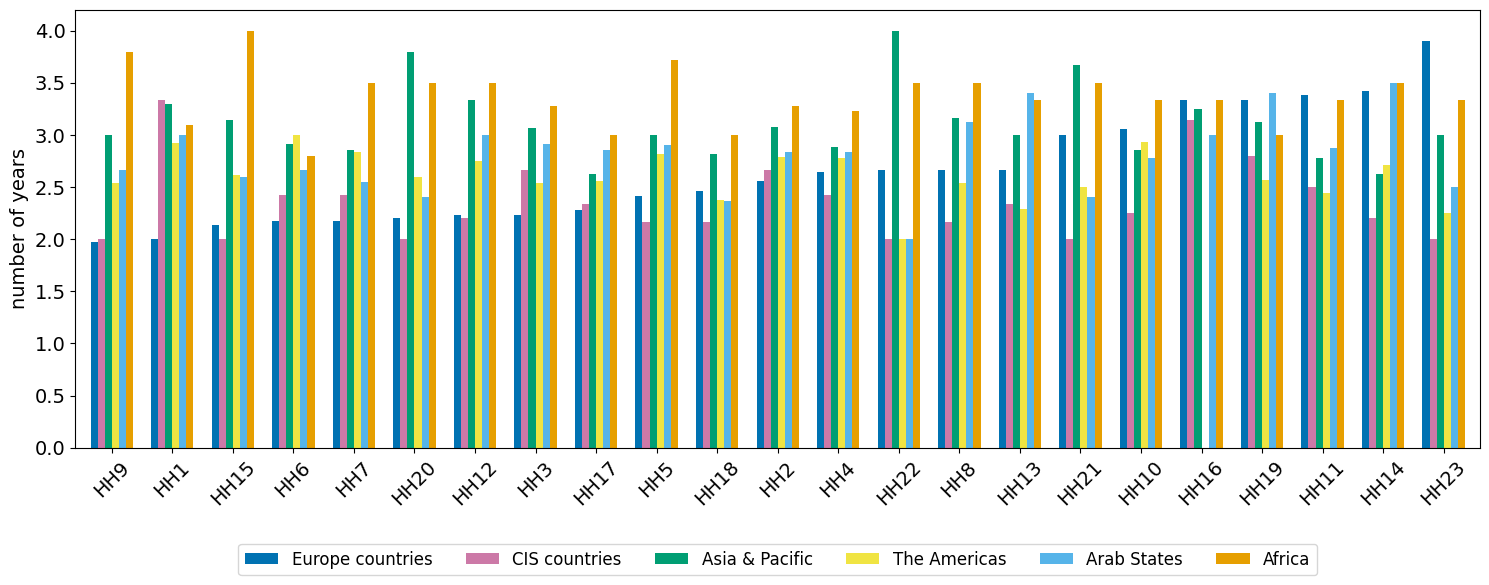

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]


rename_dict = {
    'timeliness_hh1': 'HH1',
    'timeliness_hh2': 'HH2',
    'timeliness_hh3': 'HH3',
    'timeliness_hh4': 'HH4',
    'timeliness_hh5': 'HH5',
    'timeliness_hh6': 'HH6',
    'timeliness_hh7': 'HH7',
    'timeliness_hh8': 'HH8',
    'timeliness_hh9': 'HH9',
    'timeliness_hh10': 'HH10',
    'timeliness_hh11': 'HH11',
    'timeliness_hh12': 'HH12',
    'timeliness_hh13': 'HH13',
    'timeliness_hh14': 'HH14',
    'timeliness_hh15': 'HH15',
    'timeliness_hh16': 'HH16',
    'timeliness_hh17': 'HH17',
    'timeliness_hh18': 'HH18',
    'timeliness_hh19': 'HH19',
    'timeliness_hh20': 'HH20',
    'timeliness_hh21': 'HH21',
    'timeliness_hh22': 'HH22',
    'timeliness_hh23': 'HH23',
}


hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]
hh_timeliness.extend(['regionname'])
df[hh_timeliness].rename(columns=rename_dict).groupby(['regionname']).mean().reindex(custom_order).T.sort_values(
     by='Europe countries', ascending=True).plot(kind='bar',
                                                   stacked=False,
                                                   color=custom_colors,
                                                   figsize=(15, 6),
                                                   width=0.7)
#plt.title('Timeliness in 2025: average time lag of data points in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

In [ ]:
df[df.regionname=='Europe countries'].shortname.unique()

array(['Albania', 'Andorra', 'Austria', 'Belgium',
       'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus',
       'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France',
       'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Israel', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
       'Moldova', 'Monaco', 'Montenegro', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'Türkiye', 'Ukraine', 'United Kingdom'], dtype=object)

In [ ]:
df[df.regionname=='Europe countries'].shortname.nunique()

43

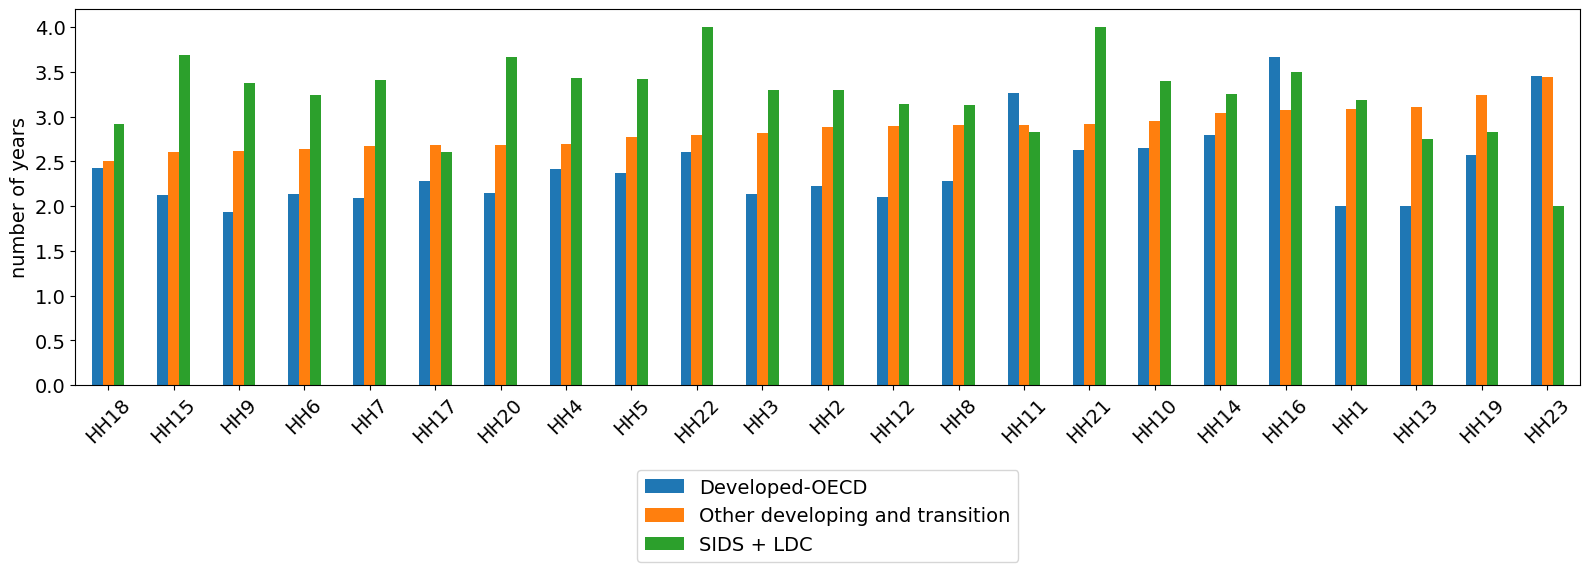

In [ ]:
# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

rename_dict = {
    'timeliness_hh1': 'HH1',
    'timeliness_hh2': 'HH2',
    'timeliness_hh3': 'HH3',
    'timeliness_hh4': 'HH4',
    'timeliness_hh5': 'HH5',
    'timeliness_hh6': 'HH6',
    'timeliness_hh7': 'HH7',
    'timeliness_hh8': 'HH8',
    'timeliness_hh9': 'HH9',
    'timeliness_hh10': 'HH10',
    'timeliness_hh11': 'HH11',
    'timeliness_hh12': 'HH12',
    'timeliness_hh13': 'HH13',
    'timeliness_hh14': 'HH14',
    'timeliness_hh15': 'HH15',
    'timeliness_hh16': 'HH16',
    'timeliness_hh17': 'HH17',
    'timeliness_hh18': 'HH18',
    'timeliness_hh19': 'HH19',
    'timeliness_hh20': 'HH20',
    'timeliness_hh21': 'HH21',
    'timeliness_hh22': 'HH22',
    'timeliness_hh23': 'HH23',
}

hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]
hh_timeliness.extend(['new_group'])
df[hh_timeliness].rename(columns=rename_dict).groupby(['new_group']).mean().reset_index().set_index('new_group').T.sort_values(
     by='Other developing and transition', ascending=True)[custom_order].plot(kind='bar', stacked=False, figsize=(16, 6))
#plt.title('Timeliness in 2025: average time lag of data points in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

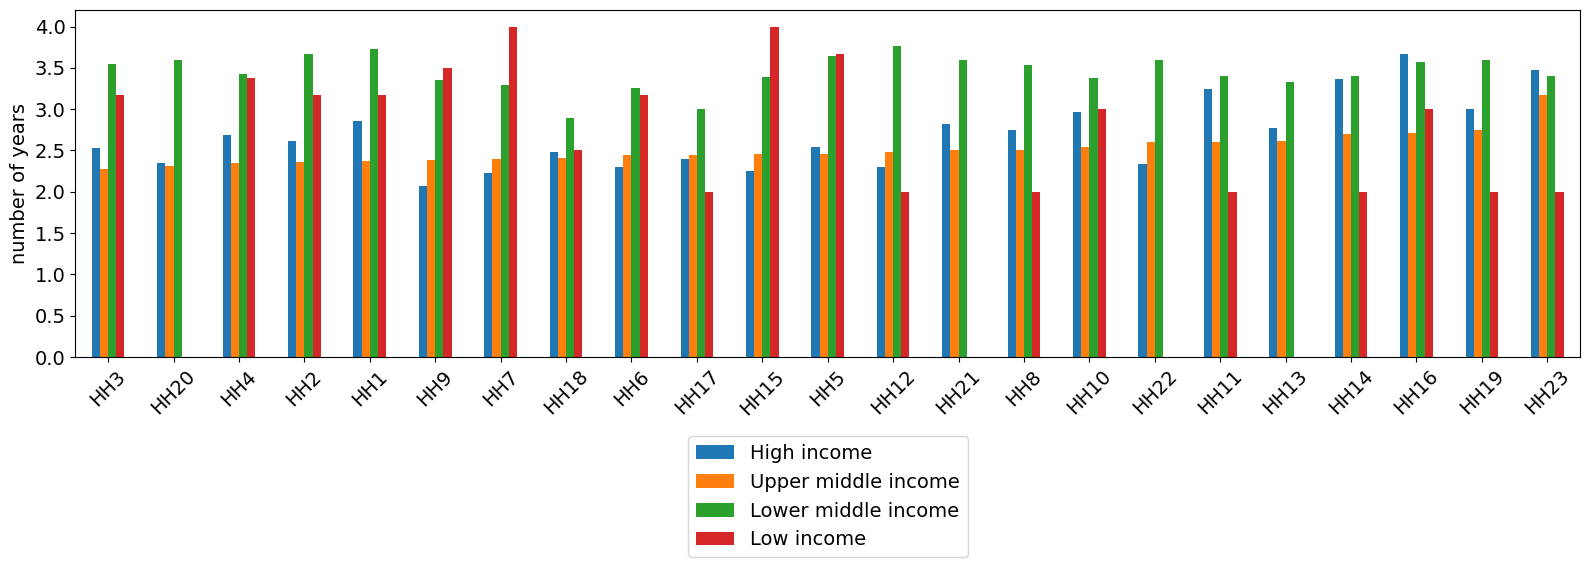

In [ ]:
# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

rename_dict = {
    'timeliness_hh1': 'HH1',
    'timeliness_hh2': 'HH2',
    'timeliness_hh3': 'HH3',
    'timeliness_hh4': 'HH4',
    'timeliness_hh5': 'HH5',
    'timeliness_hh6': 'HH6',
    'timeliness_hh7': 'HH7',
    'timeliness_hh8': 'HH8',
    'timeliness_hh9': 'HH9',
    'timeliness_hh10': 'HH10',
    'timeliness_hh11': 'HH11',
    'timeliness_hh12': 'HH12',
    'timeliness_hh13': 'HH13',
    'timeliness_hh14': 'HH14',
    'timeliness_hh15': 'HH15',
    'timeliness_hh16': 'HH16',
    'timeliness_hh17': 'HH17',
    'timeliness_hh18': 'HH18',
    'timeliness_hh19': 'HH19',
    'timeliness_hh20': 'HH20',
    'timeliness_hh21': 'HH21',
    'timeliness_hh22': 'HH22',
    'timeliness_hh23': 'HH23',
}

hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]
hh_timeliness.extend(['wb_income'])
df[hh_timeliness].rename(columns=rename_dict).groupby(['wb_income']).mean().reset_index().set_index('wb_income').T.sort_values(
     by='Upper middle income', ascending=True)[custom_order].plot(kind='bar', stacked=False, figsize=(16, 6))
#plt.title('Timeliness in 2025: average time lag of data points in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

## Apply the indicator grouping as in the case of availability


In this case I have hh1 which is 2 years old and hh3 which is 4 years old. So for the group as a whole I take the minimum (not the maximum) between the two.

In [ ]:
# define groups of indicators

entry_household = ['hh1', 'hh2', 'hh3', 'hh4', 'hh6']
entry_individual = ['hh5', 'hh7', 'hh10', 'hh18']
disaggregated_household = ['hh11', 'hh14']
disaggregated_individual = ['hh8', 'hh9', 'hh12', 'hh13', 'hh15', 'hh17', 'hh19', 'hh20', 'hh21', 'hh22','hh23']
expenditure = ['hh16']

groups = {
    'entry_household': entry_household,
    'entry_individual': entry_individual,
    'disaggregated_household': disaggregated_household,
    'disaggregated_individual': disaggregated_individual,
    'expenditure': expenditure
}

for new_col, base_cols in groups.items():
    matching_cols = [f"timeliness_{b}" for b in base_cols if f"timeliness_{b}" in df.columns]
    df[f"timeliness_{new_col}"] = df[matching_cols].min(axis=1)


In [ ]:
df.timeliness_hh1.describe()

,timeliness_hh1
count,44.0
mean,3.022727
std,1.19083
min,1.0
25%,2.0
50%,3.0
75%,4.0
max,5.0


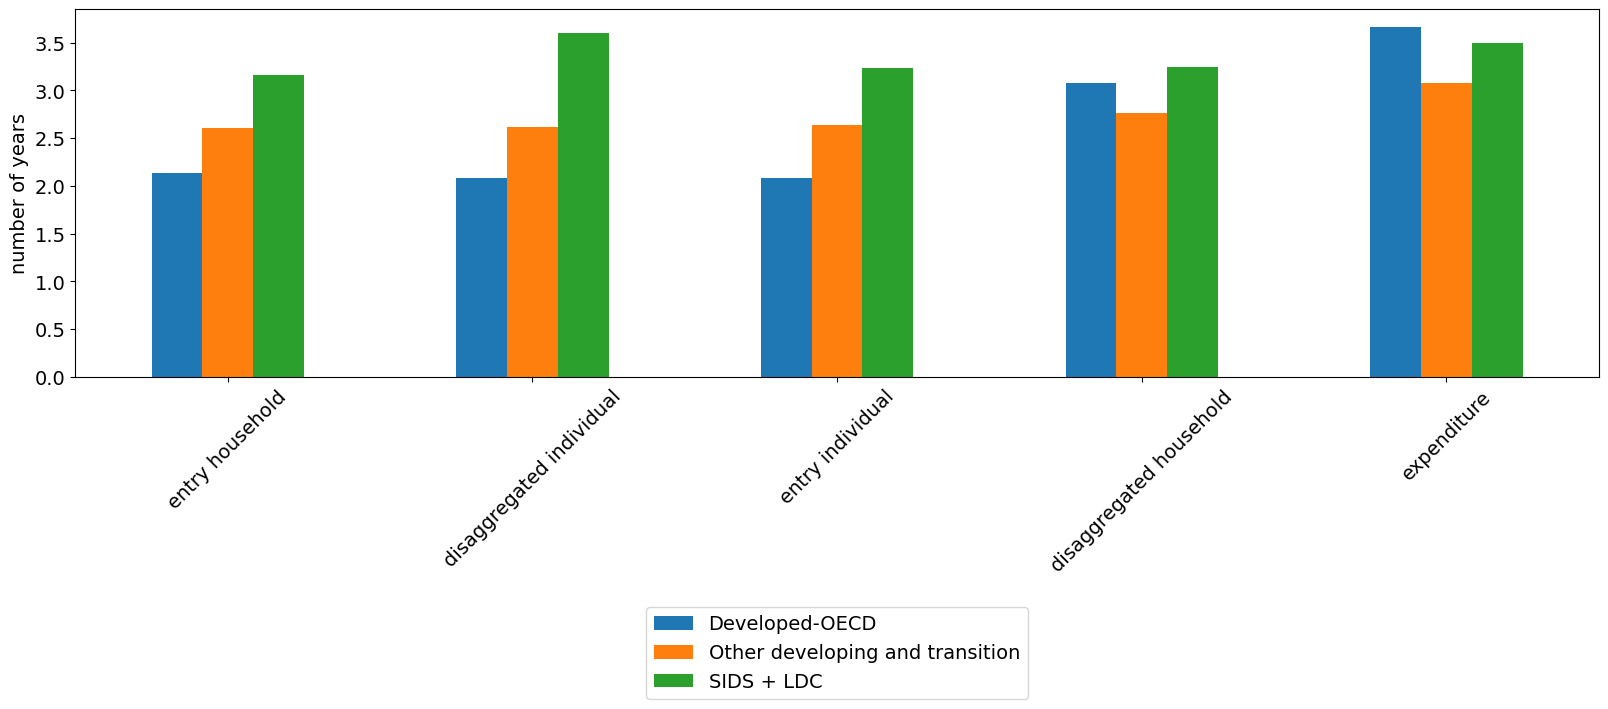

In [ ]:
# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

hh_timeliness_new = ['timeliness_entry_household',
    'timeliness_entry_individual',
    'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    'timeliness_expenditure']
hh_timeliness_new.extend(['new_group'])
df[hh_timeliness_new].rename(columns=rename_dict).groupby(['new_group']).mean().reset_index().set_index('new_group').T.sort_values(
     by='Other developing and transition', ascending=True)[custom_order].plot(kind='bar', stacked=False, figsize=(16, 6))
#plt.title('Timeliness in 2025: average time lag of data points for indicator group in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.6)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

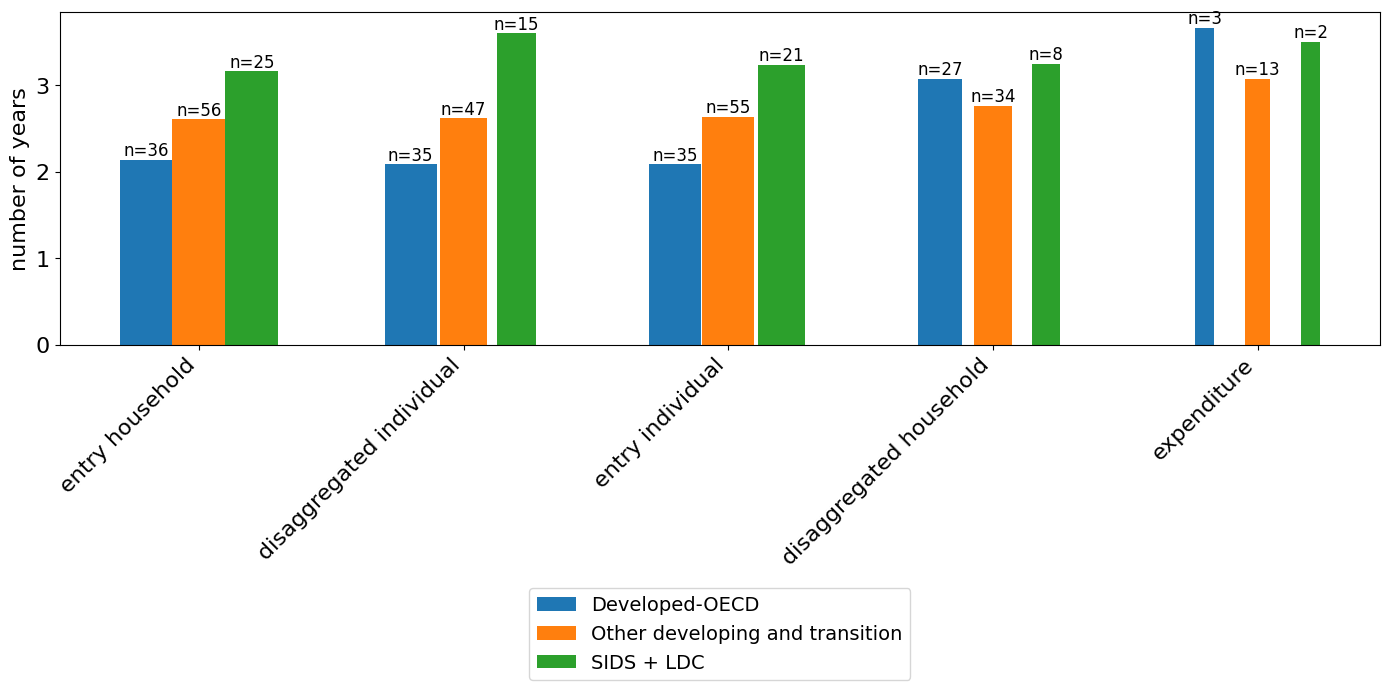

In [ ]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']
#, 'Other Economies']

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

custom_colors = ['#1f77b4',  # Blue
'#ff7f0e' , # Orange
'#2ca02c',  # Green
'#d62728'  # Red
]

subset = df[['new_group','timeliness_entry_household','timeliness_entry_individual','timeliness_disaggregated_household',
    'timeliness_disaggregated_individual','timeliness_expenditure']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('new_group').mean(numeric_only=True).T
counts = subset.groupby('new_group').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Other developing and transition', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=0
            )

ax.set_xlabel('', fontsize=16)
ax.set_ylabel('number of years', fontsize=16)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=16, ha='right')
ax.tick_params(axis='y', labelsize=16)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -.7),
    ncol=1,
    fontsize=14
)

plt.tight_layout()
plt.show()


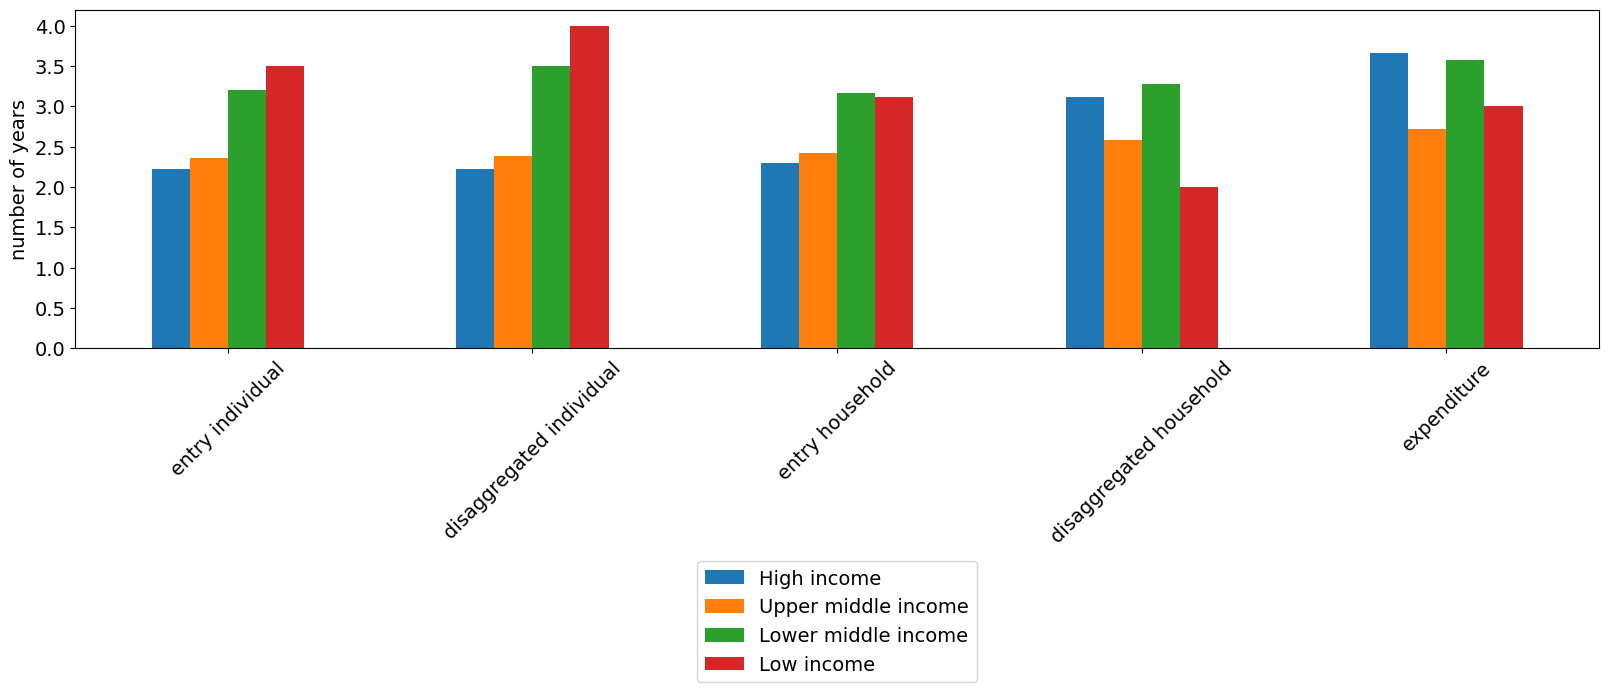

In [ ]:
# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

hh_timeliness_new = ['timeliness_entry_household',
    'timeliness_entry_individual',
    'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    'timeliness_expenditure']
hh_timeliness_new.extend(['wb_income'])
df[hh_timeliness_new].rename(columns=rename_dict).groupby(['wb_income']).mean().reset_index().set_index('wb_income').T.sort_values(
     by='Upper middle income', ascending=True)[custom_order].plot(kind='bar', stacked=False, figsize=(16, 6))
#plt.title('Timeliness in 2025: average time lag of data points for indicator group in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.6)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=1,
    fontsize=14
)
plt.tight_layout()
plt.show()

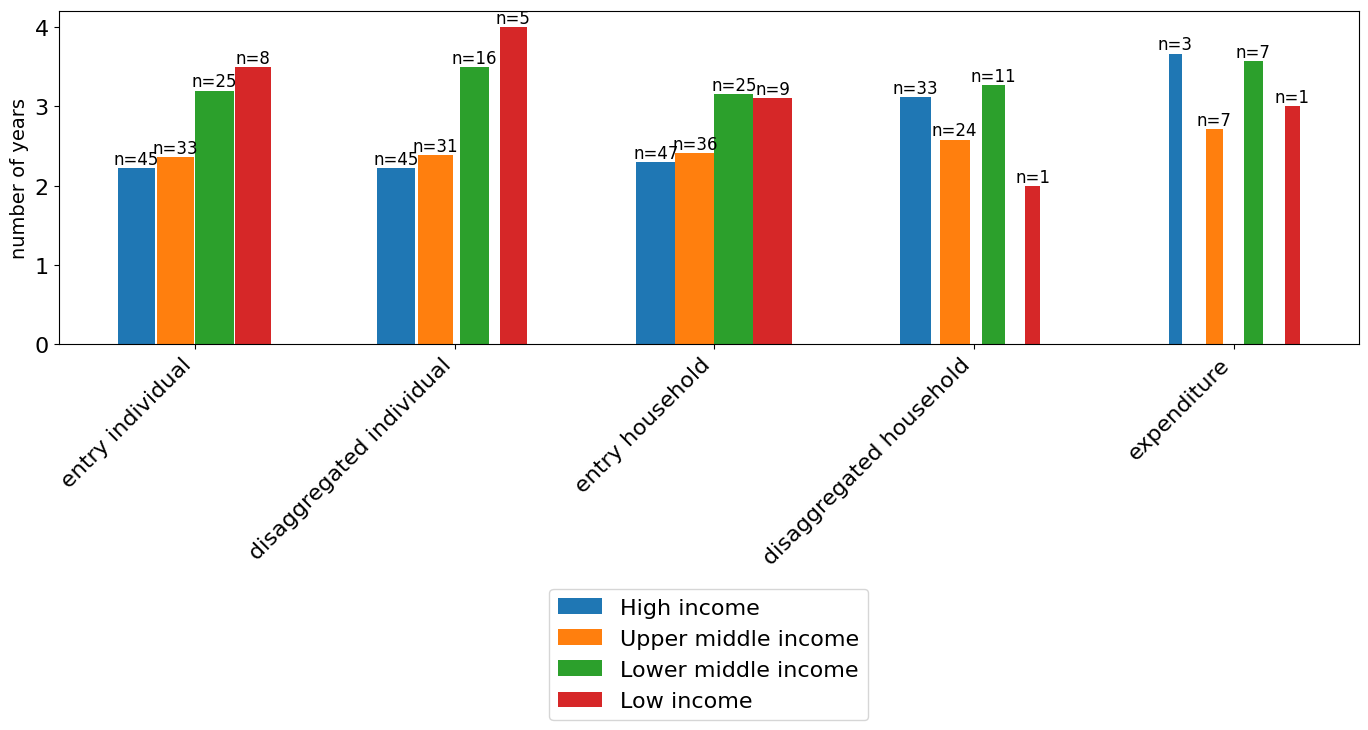

In [ ]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
#, 'Other Economies']

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

custom_colors = ['#1f77b4',  # Blue
'#ff7f0e' , # Orange
'#2ca02c',  # Green
'#d62728'  # Red
]

subset = df[['wb_income','timeliness_entry_household','timeliness_entry_individual','timeliness_disaggregated_household',
    'timeliness_disaggregated_individual','timeliness_expenditure']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('wb_income').mean(numeric_only=True).T
counts = subset.groupby('wb_income').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Upper middle income', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=12,
                rotation=0
            )

ax.set_xlabel('', fontsize=15)
ax.set_ylabel('number of years', fontsize=14)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=16, ha='right')
ax.tick_params(axis='y', labelsize=16)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -.7),
    ncol=1,
    fontsize=16
)

plt.tight_layout()
plt.show()


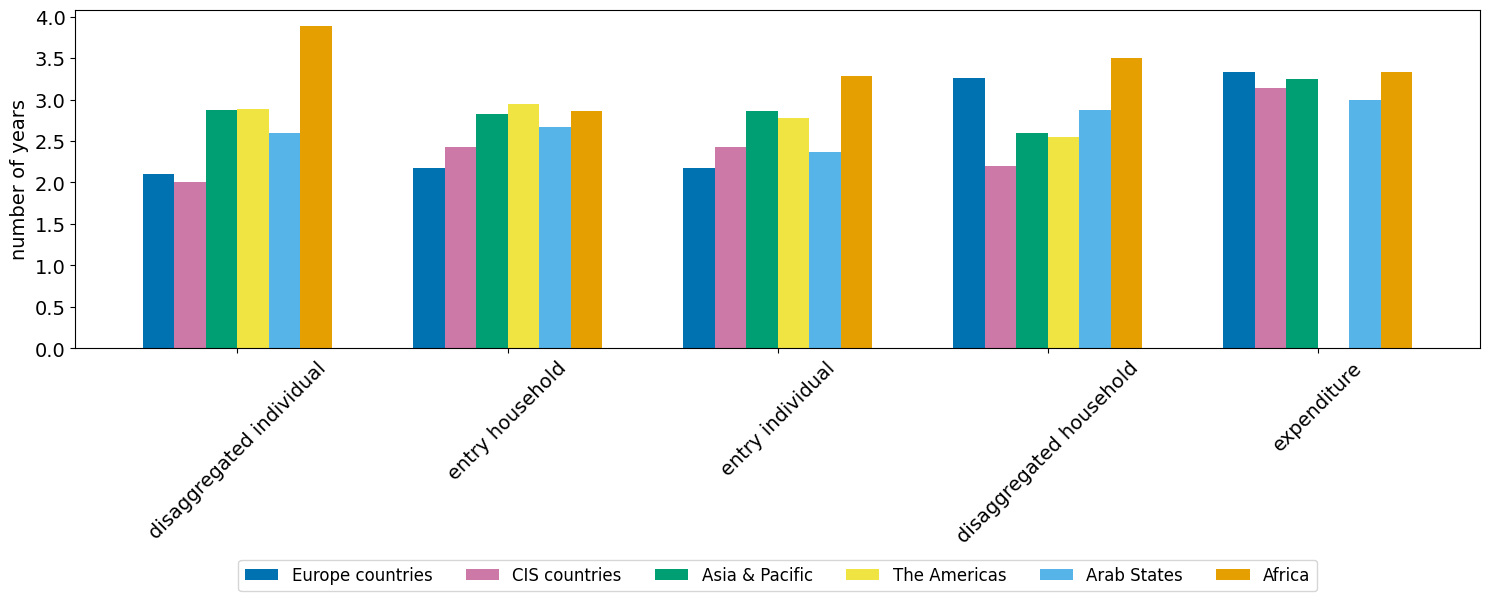

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]


rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

hh_timeliness_new = ['timeliness_entry_household',
    'timeliness_entry_individual',
    'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    'timeliness_expenditure']
hh_timeliness_new.extend(['regionname'])
df[hh_timeliness_new].rename(columns=rename_dict).groupby(['regionname']).mean().reindex(custom_order).T.sort_values(
     by='Europe countries', ascending=True).plot(kind='bar',
                                                   stacked=False,
                                                   color=custom_colors,
                                                   figsize=(15, 6),
                                                   width=0.7)
#plt.title('Timeliness in 2025: average time lag of data points for indicator group in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.35)  # increase as needed

# Step 3: Reconstruct the legend using custom order
plt.legend(
    [label_to_handle[label] for label in custom_order],
    custom_order,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=7,
    fontsize=12
)

plt.tight_layout()
plt.show()

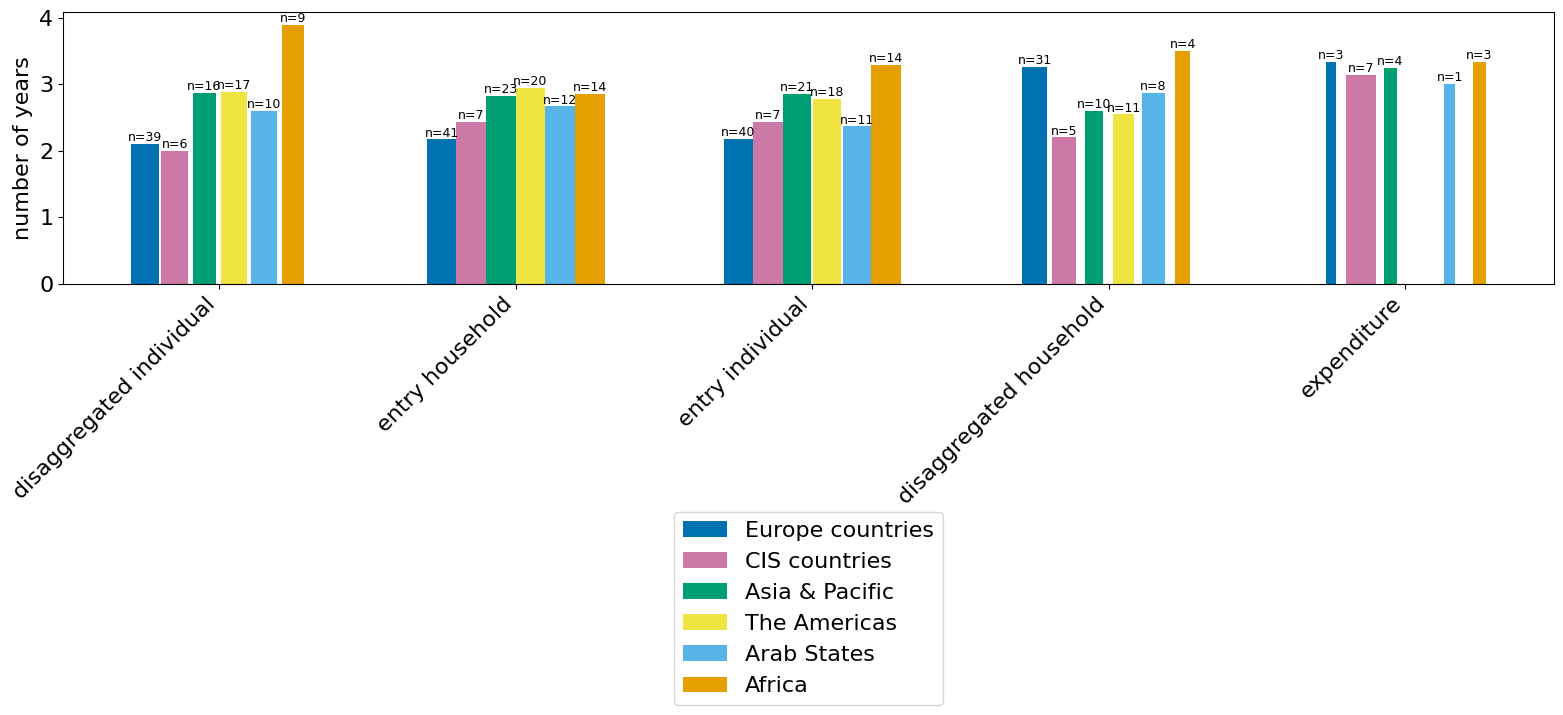

In [ ]:
from matplotlib.patches import Patch

# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    ]

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}


subset = df[['regionname','timeliness_entry_household','timeliness_entry_individual','timeliness_disaggregated_household',
    'timeliness_disaggregated_individual','timeliness_expenditure']].rename(columns=rename_dict)

# Calculate means and counts
means = subset.groupby('regionname').mean(numeric_only=True).T
counts = subset.groupby('regionname').count().T

# Sort by Europe countries
means_sorted = means.sort_values(by='Europe countries', ascending=True)[custom_order]
counts_sorted = counts.loc[means_sorted.index][custom_order]

# Set width factor range
min_width_factor = 0.3
max_width_factor = 1.0

# Create figure
fig, ax = plt.subplots(figsize=(16, 6))

# Plot each region separately to control width
x = np.arange(len(means_sorted.index))
base_width = 0.6 / len(custom_order)

for i, region in enumerate(custom_order):
    # Calculate width for each bar WITHIN THIS GROUP
    group_max_count = counts_sorted[region].max()

    # Skip if group_max_count is 0 or NaN
    if pd.isna(group_max_count) or group_max_count == 0:
        continue

    # Normalize within the group
    width_factors = counts_sorted[region] / group_max_count * (max_width_factor - min_width_factor) + min_width_factor

    # Plot bars with individual widths
    for j, (indicator, value) in enumerate(means_sorted[region].items()):
        # Skip if value is NaN
        if pd.isna(value):
            continue
        bar_width = base_width * width_factors.iloc[j]
        bar_x = x[j] + i * base_width - (len(custom_order) - 1) * base_width / 2

        ax.bar(
            bar_x,
            value,
            bar_width,
            color=custom_colors[i]
        )

        # Add text label on top of bar
        count = int(counts_sorted[region].iloc[j])
        if count > 0:
            ax.text(
                bar_x,
                value,
                f'n={count}',
                ha='center',
                va='bottom',
                fontsize=9,
                rotation=0
            )

ax.set_xlabel('', fontsize=16)
ax.set_ylabel('number of years', fontsize=16)
#plt.title('Timeliness in 2025: time lag of latest available data point in number of years (available data only)')
ax.set_xticks(x)
ax.set_xticklabels(means_sorted.index, rotation=45, fontsize=16, ha='right')
ax.tick_params(axis='y', labelsize=16)

# Create custom legend
legend_handles = [Patch(facecolor=custom_colors[i], label=region)
                  for i, region in enumerate(custom_order)] #

plt.subplots_adjust(bottom=0.7)
plt.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, -.8),
    ncol=1,
    fontsize=16
)

plt.tight_layout()
plt.show()


# COUNTRY DATA

In [ ]:
print(list(df.columns))

['country', 'HH1_5y', 'HH10_5y', 'HH11_5y', 'HH12_5y', 'HH13_5y', 'HH14_5y', 'HH15_5y', 'HH16_5y', 'HH17_5y', 'HH18_5y', 'HH19_5y', 'HH2_5y', 'HH20_5y', 'HH21_5y', 'HH22_5y', 'HH23_5y', 'HH3_5y', 'HH4_5y', 'HH5_5y', 'HH6_5y', 'HH7_5y', 'HH8_5y', 'HH9_5y', 'shortname', 'regionname', 'countrytype', 'itumember', 'ldc', 'lldc', 'sids', 'm49region', 'm49subregion', 'ison3code', 'language6', 'wb_income', 'itu_admin_region', 'umc_event_region', 'oecd_member', 'latest_year', 'number_of_years_with_available_data', 'iso3', 'hh1', 'hh2', 'hh3', 'hh4', 'hh5', 'hh6', 'hh7', 'hh8', 'hh9', 'hh10', 'hh11', 'hh12', 'hh13', 'hh14', 'hh15', 'hh16', 'hh17', 'hh18', 'hh19', 'hh20', 'hh21', 'hh22', 'hh23', 'household_composition', 'urban_rural', 'gender', 'age', 'age__gender', 'level_of_education', 'level_of_education__gender', 'labour_force_status', 'occupation', 'new_group', 'entry_household_5y', 'entry_individual_5y', 'disaggregated_household_5y', 'disaggregated_individual_5y', 'expenditure_5y', 'ShortNa

In [ ]:


rename_dict = {
'entry_household_5y': 'entry household',
'entry_individual_5y': 'entry individual',
'disaggregated_household_5y': 'disaggregated household',
'disaggregated_individual_5y': 'disaggregated individual',
'expenditure_5y': 'expenditure',
}


df[['shortname', 'iso3','regionname', 'new_group', 'wb_income','overall_source_text', 'recent_source_text','entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y', 'timeliness_entry_household', 'timeliness_entry_individual', 'timeliness_disaggregated_household', 'timeliness_disaggregated_individual', 'timeliness_expenditure']].head()
#.rename(columns=rename_dict)

,shortname,iso3,regionname,new_group,wb_income,overall_source_text,recent_source_text,entry_household_5y,entry_individual_5y,disaggregated_household_5y,disaggregated_individual_5y,expenditure_5y,timeliness_entry_household,timeliness_entry_individual,timeliness_disaggregated_household,timeliness_disaggregated_individual,timeliness_expenditure
0,Afghanistan,AFG,Asia & Pacific,SIDS + LDC,Low income,other source,NaN,1.0,NaN,NaN,NaN,NaN,2,<NA>,<NA>,<NA>,<NA>
1,Albania,ALB,Europe countries,Other developing and transition,Upper middle income,ICT survey,ICT survey,4.0,4.0,4.0,4.0,NaN,2,2,2,2,<NA>
2,Algeria,DZA,Arab States,Other developing and transition,Lower middle income,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
3,Andorra,AND,Europe countries,Other developing and transition,High income,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
4,Angola,AGO,Africa,SIDS + LDC,Lower middle income,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
export_df = df[['shortname', 'iso3','regionname', 'new_group', 'wb_income','overall_source_text', 'recent_source_text','entry_household_5y',
'entry_individual_5y',
'disaggregated_household_5y',
'disaggregated_individual_5y',
'expenditure_5y', 'timeliness_entry_household', 'timeliness_entry_individual', 'timeliness_disaggregated_household', 'timeliness_disaggregated_individual', 'timeliness_expenditure']]

In [ ]:
export_df = export_df.dropna(subset=['shortname'])

In [ ]:
df[df.shortname=='Benin'][['hh1', 'hh2', 'hh3', 'hh4', 'hh6',
'hh5', 'hh7', 'hh10', 'hh18',
'hh11', 'hh14',
'hh8', 'hh9', 'hh12', 'hh13', 'hh15', 'hh17', 'hh19', 'hh20', 'hh21', 'hh22','hh23',
'hh16']]

,hh1,hh2,hh3,hh4,hh6,hh5,hh7,hh10,hh18,hh11,...,hh12,hh13,hh15,hh17,hh19,hh20,hh21,hh22,hh23,hh16
18,2017,2017,2017,2017,2017,<NA>,2011,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
export_df

,shortname,iso3,regionname,new_group,wb_income,overall_source_text,recent_source_text,entry_household_5y,entry_individual_5y,disaggregated_household_5y,disaggregated_individual_5y,expenditure_5y,timeliness_entry_household,timeliness_entry_individual,timeliness_disaggregated_household,timeliness_disaggregated_individual,timeliness_expenditure
0,Afghanistan,AFG,Asia & Pacific,SIDS + LDC,Low income,other source,NaN,1.0,NaN,NaN,NaN,NaN,2,<NA>,<NA>,<NA>,<NA>
1,Albania,ALB,Europe countries,Other developing and transition,Upper middle income,ICT survey,ICT survey,4.0,4.0,4.0,4.0,NaN,2,2,2,2,<NA>
2,Algeria,DZA,Arab States,Other developing and transition,Lower middle income,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
3,Andorra,AND,Europe countries,Other developing and transition,High income,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
4,Angola,AGO,Africa,SIDS + LDC,Lower middle income,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,Venezuela,VEN,The Americas,Other developing and transition,NaN,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
190,Viet Nam,VNM,Asia & Pacific,Other developing and transition,Lower middle income,household survey,household survey,4.0,4.0,1.0,3.0,NaN,2,2,2,2,<NA>
191,Wallis and Futuna,WLF,Other Economies,Other developing and transition,NaN,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>
192,Zambia,ZMB,Africa,SIDS + LDC,Low income,other source,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
export_df.to_excel('hh_capacity_country.xlsx')

## New indicator: % of indicators available per year (of the 23 HH indicators) per country


We want to calculate how many HH indicators were available per country each year (max 23).

Then calculate the proportion of HH indicators available per country each year.


### Read the data availability of indicator file

In [ ]:
file_path = '/content/Data_availability_by_indicator_and_year.csv'

df_detailed = pd.read_csv(file_path)

In [ ]:
df_detailed.head()

,Country,CountryType,RegionName,Indicator,ItuMember,DataYear
0,Afghanistan,Low Income,Asia & Pacific,HH1,1,2015
1,Afghanistan,Low Income,Asia & Pacific,HH18,1,2016
2,Afghanistan,Low Income,Asia & Pacific,HH2,1,2015
3,Afghanistan,Low Income,Asia & Pacific,HH3,1,2015
4,Afghanistan,Low Income,Asia & Pacific,HH4,1,2015


In [ ]:
# the minimum year included in the dataset
df_detailed.DataYear.min()

2013

## At this point determine which is the latest year when an indicator was available

because for the other dataset ITU non members are missing

In [ ]:
df_timeliness = df_detailed.groupby(['Indicator', 'Country'])['DataYear'].max().reset_index().pivot(index='Country', columns='Indicator', values='DataYear').reset_index()

In [ ]:
df_timeliness.head()

Indicator,Country,HH1,HH10,HH11,HH12,HH13,HH14,HH15,HH16,HH17,...,HH21,HH22,HH23,HH3,HH4,HH5,HH6,HH7,HH8,HH9
0,Afghanistan,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2015.0,2015.0,2016.0,2023.0,NaN,NaN,NaN
1,Albania,2018.0,2023.0,2023.0,2023.0,NaN,2023.0,2023.0,2016.0,2023.0,...,NaN,NaN,2021.0,2018.0,2018.0,2023.0,2023.0,2023.0,NaN,2023.0
2,Algeria,2018.0,2018.0,2018.0,2018.0,NaN,2018.0,2018.0,NaN,2018.0,...,NaN,NaN,NaN,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,2017.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,NaN,2017.0,2017.0,NaN,NaN
4,Angola,2018.0,NaN,NaN,NaN,2018.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2015.0,2018.0,NaN,2018.0,2014.0,NaN,NaN


In [ ]:
# add the transformed series

hh_cols = [f'HH{i}' for i in range(1, 24)]

for col in hh_cols:
    new_col = f'timeliness_{col}'
    df_timeliness[new_col] = (2025 - df_timeliness[col]).astype('Int64')


df_timeliness.columns

Index(['Country', 'HH1', 'HH10', 'HH11', 'HH12', 'HH13', 'HH14', 'HH15',
       'HH16', 'HH17', 'HH18', 'HH19', 'HH2', 'HH20', 'HH21', 'HH22', 'HH23',
       'HH3', 'HH4', 'HH5', 'HH6', 'HH7', 'HH8', 'HH9', 'timeliness_HH1',
       'timeliness_HH2', 'timeliness_HH3', 'timeliness_HH4', 'timeliness_HH5',
       'timeliness_HH6', 'timeliness_HH7', 'timeliness_HH8', 'timeliness_HH9',
       'timeliness_HH10', 'timeliness_HH11', 'timeliness_HH12',
       'timeliness_HH13', 'timeliness_HH14', 'timeliness_HH15',
       'timeliness_HH16', 'timeliness_HH17', 'timeliness_HH18',
       'timeliness_HH19', 'timeliness_HH20', 'timeliness_HH21',
       'timeliness_HH22', 'timeliness_HH23'],
      dtype='object', name='Indicator')

In [ ]:
df_timeliness[['Country','timeliness_HH1',
       'timeliness_HH2', 'timeliness_HH3', 'timeliness_HH4', 'timeliness_HH5',
       'timeliness_HH6', 'timeliness_HH7', 'timeliness_HH8', 'timeliness_HH9',
       'timeliness_HH10', 'timeliness_HH11', 'timeliness_HH12',
       'timeliness_HH13', 'timeliness_HH14', 'timeliness_HH15',
       'timeliness_HH16', 'timeliness_HH17', 'timeliness_HH18',
       'timeliness_HH19', 'timeliness_HH20', 'timeliness_HH21',
       'timeliness_HH22', 'timeliness_HH23']].head()

Indicator,Country,timeliness_HH1,timeliness_HH2,timeliness_HH3,timeliness_HH4,timeliness_HH5,timeliness_HH6,timeliness_HH7,timeliness_HH8,timeliness_HH9,...,timeliness_HH14,timeliness_HH15,timeliness_HH16,timeliness_HH17,timeliness_HH18,timeliness_HH19,timeliness_HH20,timeliness_HH21,timeliness_HH22,timeliness_HH23
0,Afghanistan,10,10,10,10,9,2,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,9,<NA>,<NA>,<NA>,<NA>,<NA>
1,Albania,7,7,7,7,2,2,2,<NA>,2,...,2,2,9,2,<NA>,<NA>,2,<NA>,<NA>,4
2,Algeria,7,7,7,7,7,7,7,7,7,...,7,7,<NA>,7,7,<NA>,<NA>,<NA>,<NA>,<NA>
3,Andorra,<NA>,<NA>,<NA>,8,<NA>,8,8,<NA>,<NA>,...,<NA>,8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,Angola,7,7,10,7,<NA>,7,11,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,11,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
df = df.merge(df_timeliness[['Country','timeliness_HH1',
       'timeliness_HH2', 'timeliness_HH3', 'timeliness_HH4', 'timeliness_HH5',
       'timeliness_HH6', 'timeliness_HH7', 'timeliness_HH8', 'timeliness_HH9',
       'timeliness_HH10', 'timeliness_HH11', 'timeliness_HH12',
       'timeliness_HH13', 'timeliness_HH14', 'timeliness_HH15',
       'timeliness_HH16', 'timeliness_HH17', 'timeliness_HH18',
       'timeliness_HH19', 'timeliness_HH20', 'timeliness_HH21',
       'timeliness_HH22', 'timeliness_HH23']], left_on='shortname', right_on='Country', how='left')

Pivoting this data so I can get availibility per year and per country

In [ ]:
counts = (
  df_detailed.groupby(['Country','RegionName', 'CountryType', 'ItuMember', 'Indicator', 'DataYear'])
  .size()
  .reset_index(name='count')
) # counts non-NaNs automatically

# Step 1: Get unique countries and all years from column names
unique_countries = df_detailed[['Country']].drop_duplicates()

# List all years from this dataset
all_years = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

# List all HH indicators
all_hh_indicators = [f'HH{i}' for i in range(1, 24)]

# Step 4: Create base cartesian product of Country × Year
countries_years = (
    unique_countries.assign(key=1)
    .merge(pd.DataFrame({'DataYear': all_years, 'key': 1}), on='key')
    .drop(columns='key')
    .astype({'DataYear': 'int'})
)

# Step 5: Add HH indicators to the cartesian product
full_index = (
    countries_years.assign(key=1)
    .merge(pd.DataFrame({'Indicator': all_hh_indicators, 'key': 1}), on='key')
    .drop(columns='key')
)

# Step 3: Merge with the actual counts and fill missing with 0
df_by_country_year_hh = (
    full_index
    .merge(counts, on=['Country', 'DataYear', 'Indicator'], how='left')
    .fillna({'count': 0})
    .astype({'count': 'int'})
    .sort_values(['Country', 'DataYear'])
)


In [ ]:
### correct for all of those NAs under regionname and countrytype
df_by_country_year_hh['RegionName'] = (
    df_by_country_year_hh
    .groupby('Country')['RegionName']
    .transform(lambda x: x.ffill().bfill())
)

df_by_country_year_hh['CountryType'] = (
    df_by_country_year_hh
    .groupby('Country')['CountryType']
    .transform(lambda x: x.ffill().bfill())
)

df_by_country_year_hh['ItuMember'] = (
    df_by_country_year_hh
    .groupby('Country')['ItuMember']
    .transform(lambda x: x.ffill().bfill())
)

/tmp/ipython-input-1529133037.py:5: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipython-input-1529133037.py:11: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [ ]:
# checking for one country, one year to see the counts are correct

df_by_country_year_hh[(df_by_country_year_hh['Country']=='Afghanistan') & (df_by_country_year_hh['DataYear']== 2016)]

,Country,DataYear,Indicator,RegionName,CountryType,ItuMember,count
69,Afghanistan,2016,HH1,Asia & Pacific,Low Income,1.0,0
70,Afghanistan,2016,HH2,Asia & Pacific,Low Income,1.0,0
71,Afghanistan,2016,HH3,Asia & Pacific,Low Income,1.0,0
72,Afghanistan,2016,HH4,Asia & Pacific,Low Income,1.0,0
73,Afghanistan,2016,HH5,Asia & Pacific,Low Income,1.0,1
74,Afghanistan,2016,HH6,Asia & Pacific,Low Income,1.0,0
75,Afghanistan,2016,HH7,Asia & Pacific,Low Income,1.0,0
76,Afghanistan,2016,HH8,Asia & Pacific,Low Income,1.0,0
77,Afghanistan,2016,HH9,Asia & Pacific,Low Income,1.0,0
78,Afghanistan,2016,HH10,Asia & Pacific,Low Income,1.0,0


Now this dataset needs to be rendered by country x year. In it I calculate how many indicators are available (out of the 23)

In [ ]:
df_by_country_year = df_by_country_year_hh.groupby(['Country', 'DataYear'])['count'].sum().reset_index()

In [ ]:
df_by_country_year.rename(columns={'count': 'nb_hh_available'}, inplace=True)

df_by_country_year['pct_hh_available'] = df_by_country_year['nb_hh_available'] / 23 *100

In [ ]:
# checking country by country for José
df_by_country_year[(df_by_country_year['DataYear']>2015) & (df_by_country_year['Country'].str.contains('Albania'))]

,Country,DataYear,nb_hh_available,pct_hh_available
15,Albania,2016,4,17.391304
16,Albania,2017,5,21.739130
17,Albania,2018,5,21.739130
18,Albania,2019,10,43.478261
19,Albania,2020,11,47.826087
20,Albania,2021,12,52.173913
21,Albania,2022,11,47.826087
22,Albania,2023,11,47.826087
23,Albania,2024,0,0.000000


In [ ]:
# just checking it makes sense
df_by_country_year[(df_by_country_year['Country']=='Afghanistan')]

,Country,DataYear,nb_hh_available,pct_hh_available
0,Afghanistan,2013,0,0.000000
1,Afghanistan,2014,0,0.000000
2,Afghanistan,2015,4,17.391304
3,Afghanistan,2016,2,8.695652
4,Afghanistan,2017,0,0.000000
5,Afghanistan,2018,0,0.000000
6,Afghanistan,2019,0,0.000000
7,Afghanistan,2020,0,0.000000
8,Afghanistan,2021,0,0.000000
9,Afghanistan,2022,0,0.000000


Retrieve from the original data file the development group. I can do the join on country name because these are standard ITU country names

In [ ]:
df_by_country_year = df_by_country_year.merge(df[['shortname', 'countrytype', 'new_group', 'overall_source','ison3code', 'regionname', 'wb_income']], left_on='Country', right_on='shortname', how='left')


Grouping the data again by year x country type so we can build a line chart evolution over time by development group

In [ ]:
df_by_country_year[['DataYear', 'countrytype', 'pct_hh_available']].groupby(['countrytype', 'DataYear']).mean('pct_hh_available').reset_index().sort_values(by=['countrytype', 'DataYear'])

,countrytype,DataYear,pct_hh_available
0,Developed,2013,35.416667
1,Developed,2014,28.804348
2,Developed,2015,33.061594
3,Developed,2016,31.431159
4,Developed,2017,39.221014
5,Developed,2018,26.811594
6,Developed,2019,32.155797
7,Developed,2020,30.072464
8,Developed,2021,34.239130
9,Developed,2022,25.905797


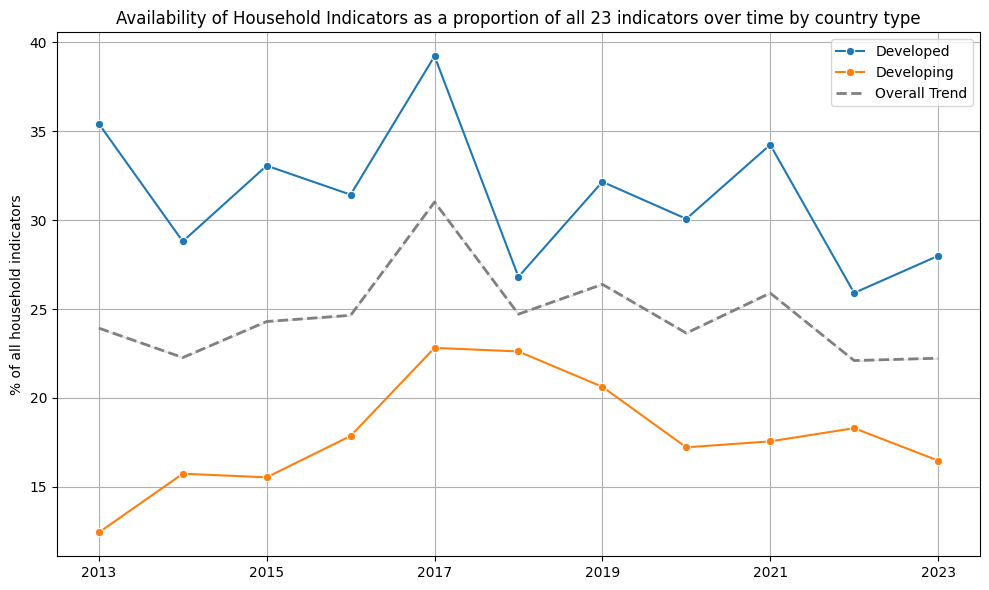

In [ ]:
df_line = (
    df_by_country_year[df_by_country_year.DataYear <= 2023][['DataYear', 'countrytype', 'pct_hh_available']]
    .groupby(['countrytype', 'DataYear'], as_index=False)
    .mean(numeric_only=True)
    .sort_values(by=['countrytype', 'DataYear'])
)

# Compute average pct_hh_available by year (all countries combined)
df_line['trend'] = df_line[['pct_hh_available', 'DataYear']].groupby('DataYear').transform(lambda x: x.rolling(window=7, center=True, min_periods=1).mean())


# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='pct_hh_available',
    hue='countrytype',        # Two lines, one for each country type
    marker='o'                # Optional: dots on the line
)

# Overlay trend line
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='trend',
    color='gray',
    linewidth=2,
    linestyle='--',
    label='Overall Trend',
    legend=False            # Don't repeat the legend
)

plt.title("Availability of Household Indicators as a proportion of all 23 indicators over time by country type")
plt.xlabel("")
plt.xticks(ticks=range(df_line['DataYear'].min(), df_line['DataYear'].max() + 1, 2))
plt.ylabel("% of all household indicators")
plt.legend(title="")
plt.grid(True)
plt.tight_layout()
plt.show()

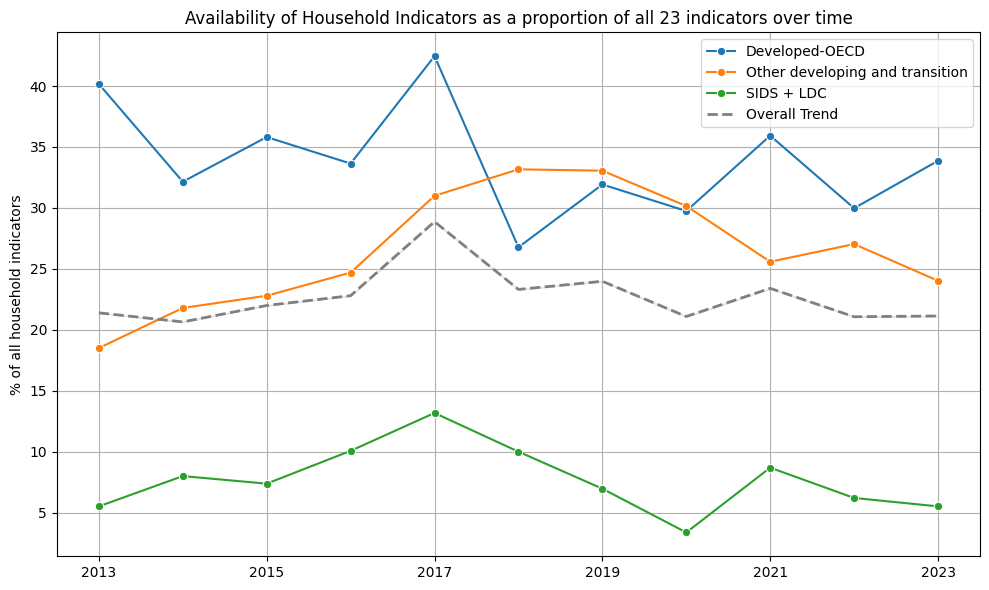

In [ ]:
# Define your custom order
custom_order = ['Developed-OECD', 'Other developing and transition', 'SIDS + LDC']

df_line = (
    df_by_country_year[df_by_country_year.DataYear <= 2023][['DataYear', 'new_group', 'pct_hh_available']]
    .groupby(['new_group', 'DataYear'], as_index=False)
    .mean(numeric_only=True)
    .sort_values(by=['new_group', 'DataYear'])
)

# Compute average pct_hh_available by year (all countries combined)
df_line['trend'] = df_line[['pct_hh_available', 'DataYear']].groupby('DataYear').transform(lambda x: x.rolling(window=7, center=True, min_periods=1).mean())


# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='pct_hh_available',
    hue='new_group',        # Two lines, one for each country type
    hue_order=custom_order,
    marker='o'
)

# Overlay trend line
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='trend',
    color='gray',
    linewidth=2,
    linestyle='--',
    label='Overall Trend',
    legend=False            # Don't repeat the legend
)

plt.title("Availability of Household Indicators as a proportion of all 23 indicators over time")
plt.xlabel("")
plt.xticks(ticks=range(df_line['DataYear'].min(), df_line['DataYear'].max() + 1, 2))
plt.ylabel("% of all household indicators")
plt.legend(title="")
plt.grid(True)
plt.tight_layout()
plt.show()

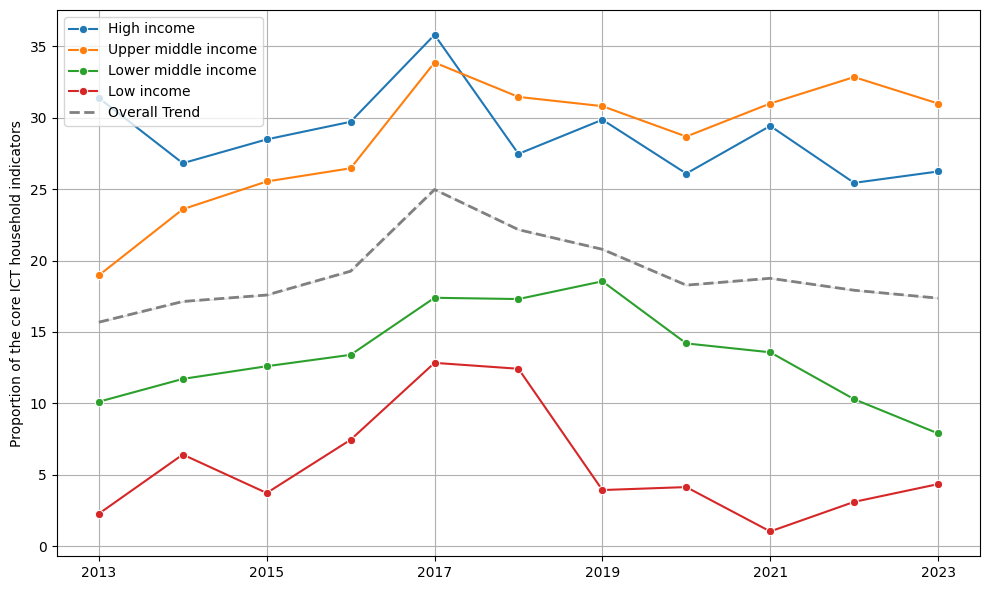

In [ ]:
# Define your custom order
custom_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

df_line = (
    df_by_country_year[df_by_country_year.DataYear <= 2023][['DataYear', 'wb_income', 'pct_hh_available']]
    .groupby(['wb_income', 'DataYear'], as_index=False)
    .mean(numeric_only=True)
    .sort_values(by=['wb_income', 'DataYear'])
)

# Compute average pct_hh_available by year (all countries combined)
df_line['trend'] = df_line[['pct_hh_available', 'DataYear']].groupby('DataYear').transform(lambda x: x.rolling(window=7, center=True, min_periods=1).mean())


# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='pct_hh_available',
    hue='wb_income',        # Two lines, one for each country type
    hue_order=custom_order,
    marker='o'
)

# Overlay trend line
sns.lineplot(
    data=df_line,
    x='DataYear',
    y='trend',
    color='gray',
    linewidth=2,
    linestyle='--',
    label='Overall Trend',
    legend=False            # Don't repeat the legend
)

#plt.title("Availability of Household Indicators as a proportion of all 23 indicators over time")
plt.xlabel("")
plt.xticks(ticks=range(df_line['DataYear'].min(), df_line['DataYear'].max() + 1, 2))
plt.ylabel("Proportion of the core ICT household indicators")
plt.legend(title="")
plt.grid(True)
plt.tight_layout()
plt.show()

### Obtain bar charts for the availability indicator as well

Need to start from the dataset by country year and indicator.

Filter data for availability in 2020-2024 (last 5 years).

Group by country group and get the average indicator.

In [ ]:
df_by_country_year[df_by_country_year.DataYear >= 2020].groupby("new_group")[
    "nb_hh_available"
].mean().reset_index().sort_values(by="nb_hh_available", ascending=False)


,new_group,nb_hh_available
0,Developed-OECD,6.773684
1,Other developing and transition,5.620513
2,SIDS + LDC,1.238095


In [ ]:
# if we want data by indicator, but this is too similar to number vaialbale in last 5 years

#df_by_country_year_hh[df_by_country_year_hh.DataYear >= 2020].pivot(
 #   index=["Country", "DataYear"], columns="Indicator", values="count"
#).reset_index().groupby('Country').mean().reset_index()

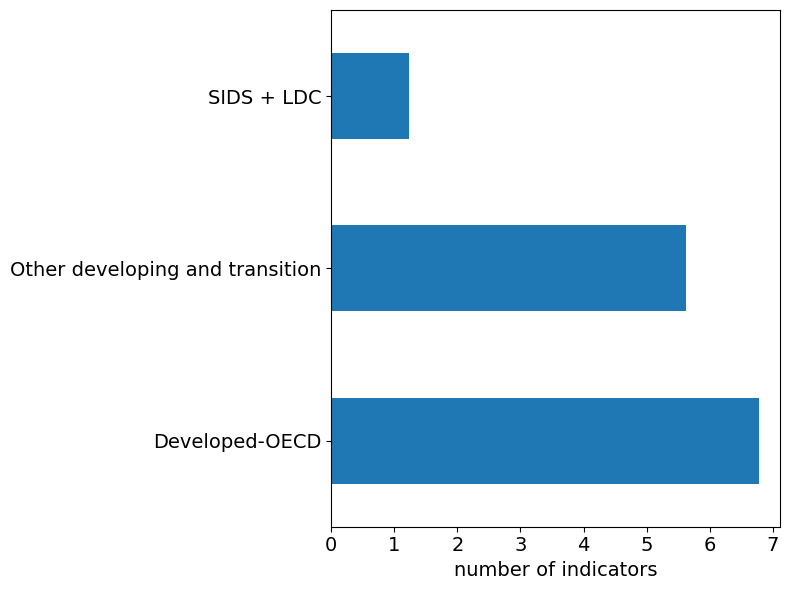

In [ ]:

df_by_country_year[df_by_country_year.DataYear >= 2020].groupby("new_group")[
    "nb_hh_available"
].mean().reset_index().sort_values(by="nb_hh_available", ascending=False
                                   ).set_index('new_group').plot(kind='barh', stacked=False, figsize=(8, 6))




#plt.title('Average number of core HH indicators available by country group (2020-2024)', fontsize=12)
plt.ylabel('')
plt.xlabel('number of indicators', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend().remove()




plt.tight_layout()
plt.show()

In [ ]:

df_by_country_year[df_by_country_year.DataYear >= 2020].groupby("regionname")[
    "nb_hh_available"
].mean().reset_index().sort_values(by="nb_hh_available")

,regionname,nb_hh_available
5,Other Economies,1.036364
0,Africa,1.054054
2,Asia & Pacific,4.141176
6,The Americas,4.517241
1,Arab States,5.000000
4,Europe countries,6.709524
3,CIS countries,9.422222


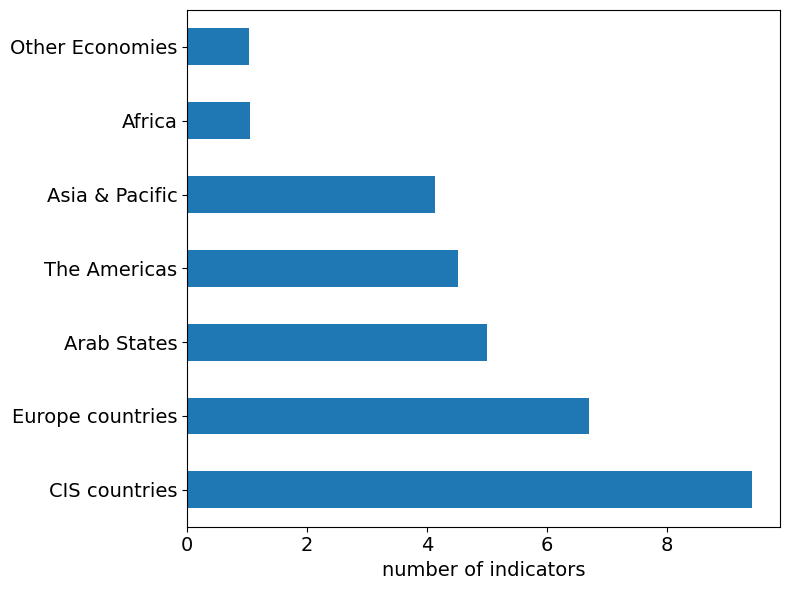

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa', 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00',  # Orange
    '#696969'
    #'#999999',   # Grey
    ]

df_by_country_year[df_by_country_year.DataYear >= 2020].groupby("regionname")[
    "nb_hh_available"
].mean().reset_index().sort_values(by="nb_hh_available", ascending=False
                                   ).set_index('regionname').plot(kind='barh',
                                                                  stacked=False,
                                                                  figsize=(8, 6))




#plt.title('Average number of core HH indicators available by country group (2020-2024)', fontsize=12)
plt.ylabel('')
plt.xlabel('number of indicators', fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.legend().remove()




plt.tight_layout()
plt.show()

## Country Profile charts

In [ ]:
df_detailed[(df_detailed.Country=='Brazil') & (df_detailed.Indicator == 'HH12') & (df_detailed.DataYear>= 2020) ]

,Country,CountryType,RegionName,Indicator,ItuMember,DataYear
1289,Brazil,Upper Middle Income,The Americas,HH12,1,2021
1290,Brazil,Upper Middle Income,The Americas,HH12,1,2022
1291,Brazil,Upper Middle Income,The Americas,HH12,1,2023
1292,Brazil,Upper Middle Income,The Americas,HH12,1,2024


In [ ]:
# prepping my data to draw a barcode plot

years = [2020, 2021, 2022, 2023, 2024]

codes = hh_cols

# limit data to the past 5 years and to the country of choice
# we only need to know if the data is available or missing
df_country = df_detailed[(df_detailed.Country == 'Brazil') & (df_detailed.DataYear>= 2020)].pivot(index='Indicator', columns='DataYear', values ='DataYear').reindex(columns=years, index=codes).notna().astype(int).reset_index()


df_country

DataYear,Indicator,2020,2021,2022,2023,2024
0,HH1,1,1,1,1,1
1,HH2,1,1,1,1,1
2,HH3,1,1,1,1,1
3,HH4,1,1,1,1,1
4,HH5,1,1,1,1,1
5,HH6,1,1,1,1,1
6,HH7,1,1,1,1,1
7,HH8,1,1,1,1,1
8,HH9,1,1,1,1,1
9,HH10,1,1,1,1,1


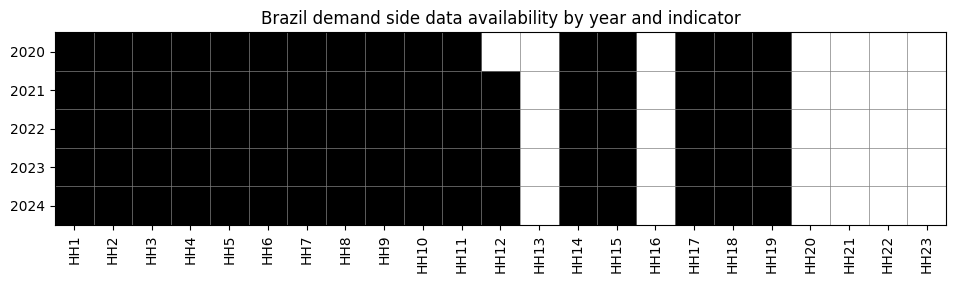

In [ ]:
# Convert DataFrame to numpy array
code_array = df_country.set_index( 'Indicator').T.to_numpy()

fig, ax = plt.subplots(figsize=(code_array.shape[1] * 0.5, code_array.shape[0] * 0.5))

# Show barcode
ax.imshow(code_array, cmap='binary', aspect='auto', interpolation='nearest')

# Set row labels (y-axis)
ax.set_yticks(np.arange(code_array.shape[0]))
ax.set_yticklabels(df_country.set_index( 'Indicator').T.index)

# Set column labels (x-axis)
ax.set_xticks(np.arange(code_array.shape[1]))
ax.set_xticklabels(df_country.set_index( 'Indicator').T.columns, rotation=90)

ax.set_title('Brazil demand side data availability by year and indicator')

# Optional: remove grid / frame
ax.set_xticks(np.arange(-.5, code_array.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, code_array.shape[0], 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

plt.show()

In [ ]:
df[['HH1_5y','HH2_5y','HH3_5y','HH4_5y',
 'HH5_5y','HH6_5y','HH7_5y','HH8_5y',
 'HH9_5y','HH10_5y','HH11_5y','HH12_5y',
 'HH13_5y','HH14_5y','HH15_5y','HH16_5y',
 'HH17_5y','HH18_5y','HH19_5y','HH20_5y',
 'HH21_5y','HH22_5y','HH23_5y']][df.shortname=='Brazil'].rename(
     columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=False)

,0
HH1_5y,4.0
HH2_5y,4.0
HH3_5y,4.0
HH4_5y,4.0
HH5_5y,4.0
HH6_5y,4.0
HH7_5y,4.0
HH8_5y,4.0
HH9_5y,4.0
HH10_5y,4.0


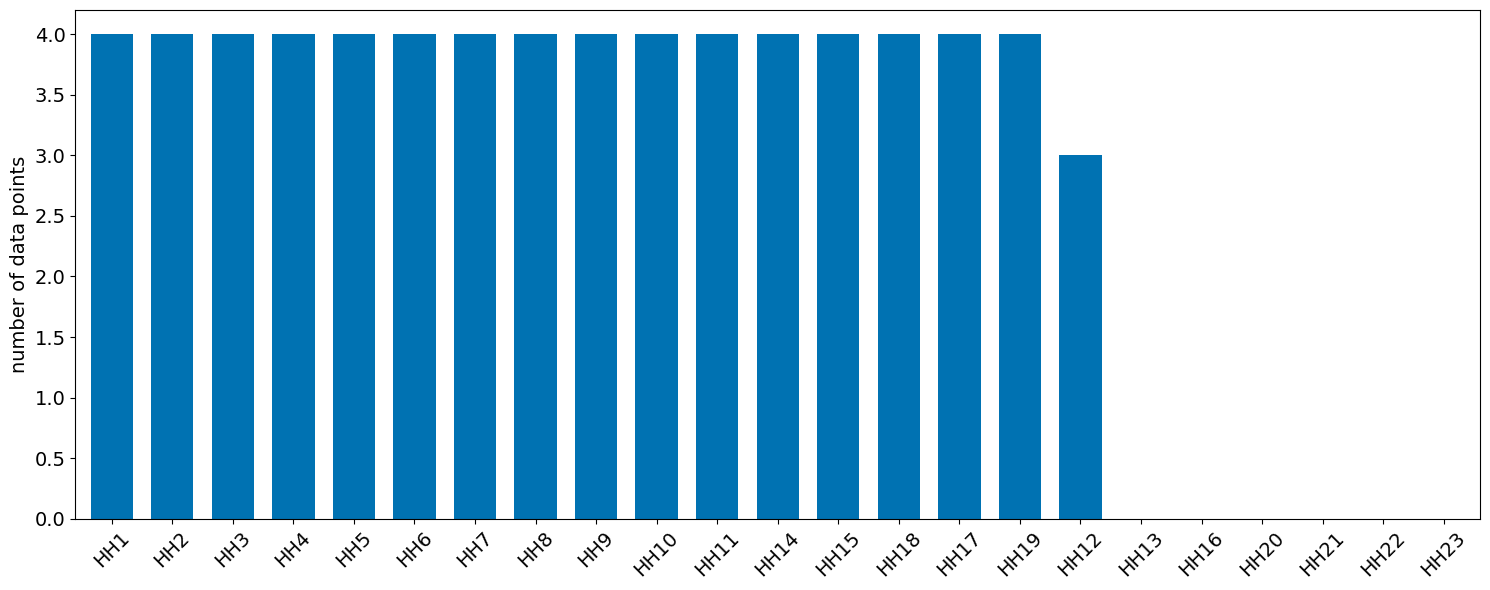

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]

rename_dict = {
 'HH1_5y': 'HH1',
 'HH2_5y': 'HH2',
 'HH3_5y': 'HH3',
 'HH4_5y': 'HH4',
 'HH5_5y': 'HH5',
 'HH6_5y': 'HH6',
 'HH7_5y': 'HH7',
 'HH8_5y': 'HH8',
 'HH9_5y': 'HH9',
 'HH10_5y': 'HH10',
 'HH11_5y': 'HH11',
 'HH12_5y': 'HH12',
 'HH13_5y': 'HH13',
 'HH14_5y': 'HH14',
 'HH15_5y': 'HH15',
 'HH16_5y': 'HH16',
 'HH17_5y': 'HH17',
 'HH18_5y': 'HH18',
 'HH19_5y': 'HH19',
 'HH20_5y': 'HH20',
 'HH21_5y': 'HH21',
 'HH22_5y': 'HH22',
 'HH23_5y': 'HH23',
}

df[['HH1_5y','HH2_5y','HH3_5y','HH4_5y',
 'HH5_5y','HH6_5y','HH7_5y','HH8_5y',
 'HH9_5y','HH10_5y','HH11_5y','HH12_5y',
 'HH13_5y','HH14_5y','HH15_5y','HH16_5y',
 'HH17_5y','HH18_5y','HH19_5y','HH20_5y',
 'HH21_5y','HH22_5y','HH23_5y']][df.shortname=='Brazil'].rename(
     columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)
#plt.title('Average number of data points per indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.legend().remove()

plt.ylabel('number of data points', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))


plt.tight_layout()
plt.show()

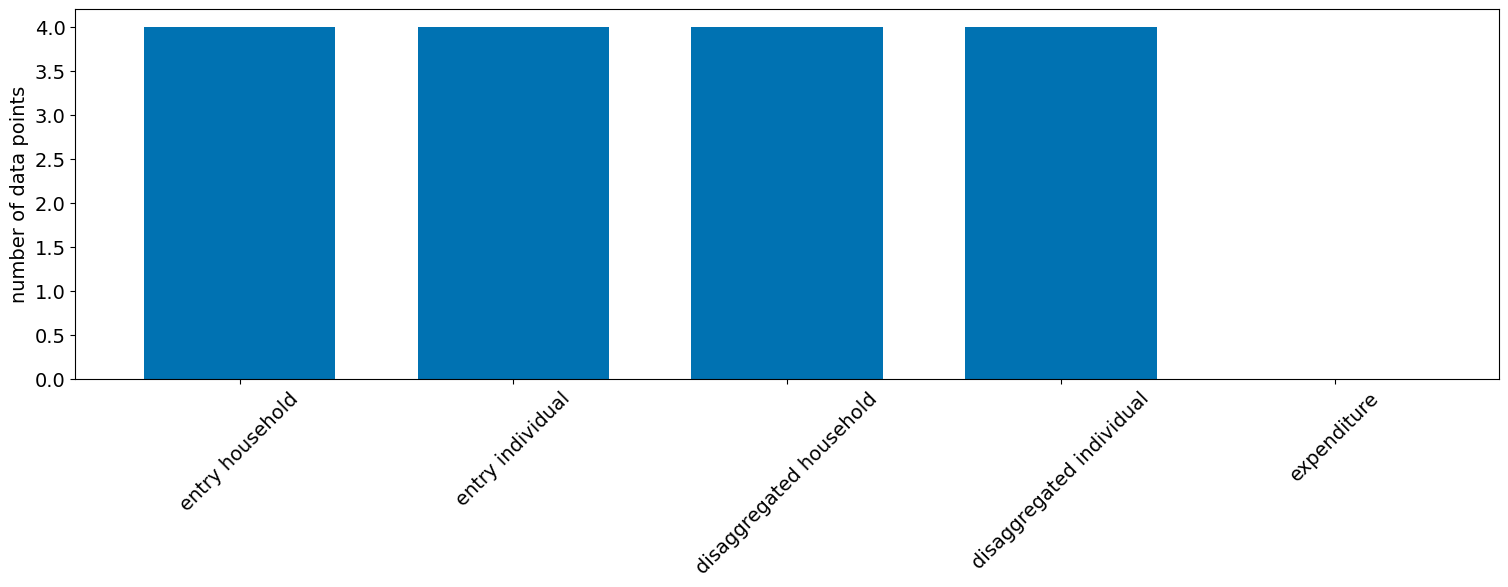

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'#,  # Orange
    ]

rename_dict = {
    'entry_household_5y': 'entry household',
    'entry_individual_5y': 'entry individual',
    'disaggregated_household_5y': 'disaggregated household',
    'disaggregated_individual_5y': 'disaggregated individual',
    'expenditure_5y': 'expenditure',
}

df[['entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']].rename(
     columns=rename_dict)[df.shortname=='Brazil'].rename(
     columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=False).plot(kind='bar',
                                                  figsize=(15, 6),
                                                  color=custom_colors,
                                                  width=0.7)

#plt.title('Average number of data points per group of indicator in the past 5 years (2020-2024)')
plt.xlabel('')
plt.ylabel('number of data points',fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

plt.legend().remove()

# Make more room at the bottom
plt.subplots_adjust(bottom=0.7)  # increase as needed


plt.tight_layout()
plt.show()

In [ ]:

rename_dict = {
    'timeliness_hh1': 'HH1',
    'timeliness_hh2': 'HH2',
    'timeliness_hh3': 'HH3',
    'timeliness_hh4': 'HH4',
    'timeliness_hh5': 'HH5',
    'timeliness_hh6': 'HH6',
    'timeliness_hh7': 'HH7',
    'timeliness_hh8': 'HH8',
    'timeliness_hh9': 'HH9',
    'timeliness_hh10': 'HH10',
    'timeliness_hh11': 'HH11',
    'timeliness_hh12': 'HH12',
    'timeliness_hh13': 'HH13',
    'timeliness_hh14': 'HH14',
    'timeliness_hh15': 'HH15',
    'timeliness_hh16': 'HH16',
    'timeliness_hh17': 'HH17',
    'timeliness_hh18': 'HH18',
    'timeliness_hh19': 'HH19',
    'timeliness_hh20': 'HH20',
    'timeliness_hh21': 'HH21',
    'timeliness_hh22': 'HH22',
    'timeliness_hh23': 'HH23',
}

hh_timeliness = [f'timeliness_hh{i}' for i in range(1, 24)]
df_plot_t = df[hh_timeliness][df.shortname=='Brazil'].rename(columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=True)

In [ ]:
df_plot_t[0]= pd.to_numeric(df_plot_t[0], errors="coerce")

In [ ]:
df_plot_t.dtypes

,0
0,float64


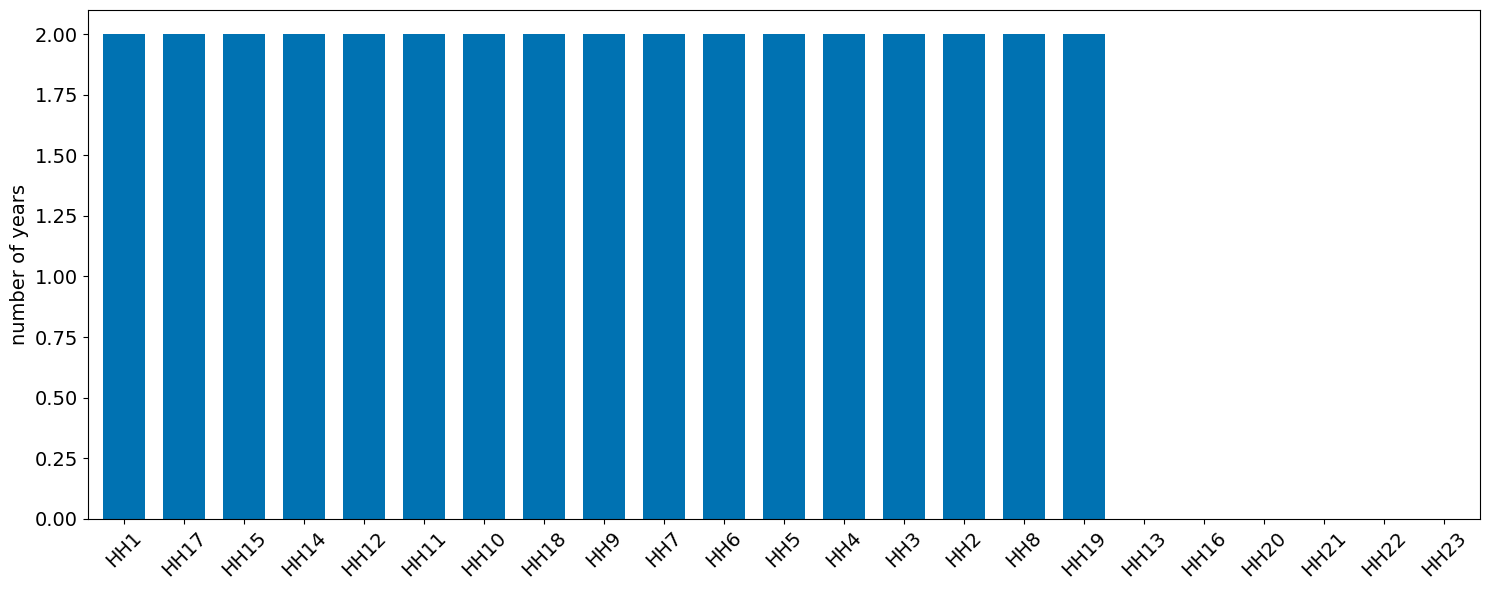

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']
#, 'Other Economies']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]



df_plot_t.plot(kind='bar',
                                                   stacked=False,
                                                   color=custom_colors,
                                                   figsize=(15, 6),
                                                   width=0.7)
#plt.title('Timeliness in 2025: average time lag of data points in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

plt.legend().remove()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))


plt.tight_layout()
plt.show()

In [ ]:

rename_dict = {
    'timeliness_entry_household': 'entry household',
    'timeliness_entry_individual': 'entry individual',
    'timeliness_disaggregated_household': 'disaggregated household',
    'timeliness_disaggregated_individual': 'disaggregated individual',
    'timeliness_expenditure': 'expenditure',
}

hh_timeliness_new = ['timeliness_entry_household',
    'timeliness_entry_individual',
    'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    'timeliness_expenditure']

df_plot_t_g = df[hh_timeliness_new][df.shortname=='Brazil'].rename(columns=rename_dict).reset_index().T.drop("index").sort_values(by=[0], ascending=True)
df_plot_t_g[0]= pd.to_numeric(df_plot_t_g[0], errors="coerce")

df_plot_t_g

,0
entry household,2.0
entry individual,2.0
disaggregated household,2.0
disaggregated individual,2.0
expenditure,NaN


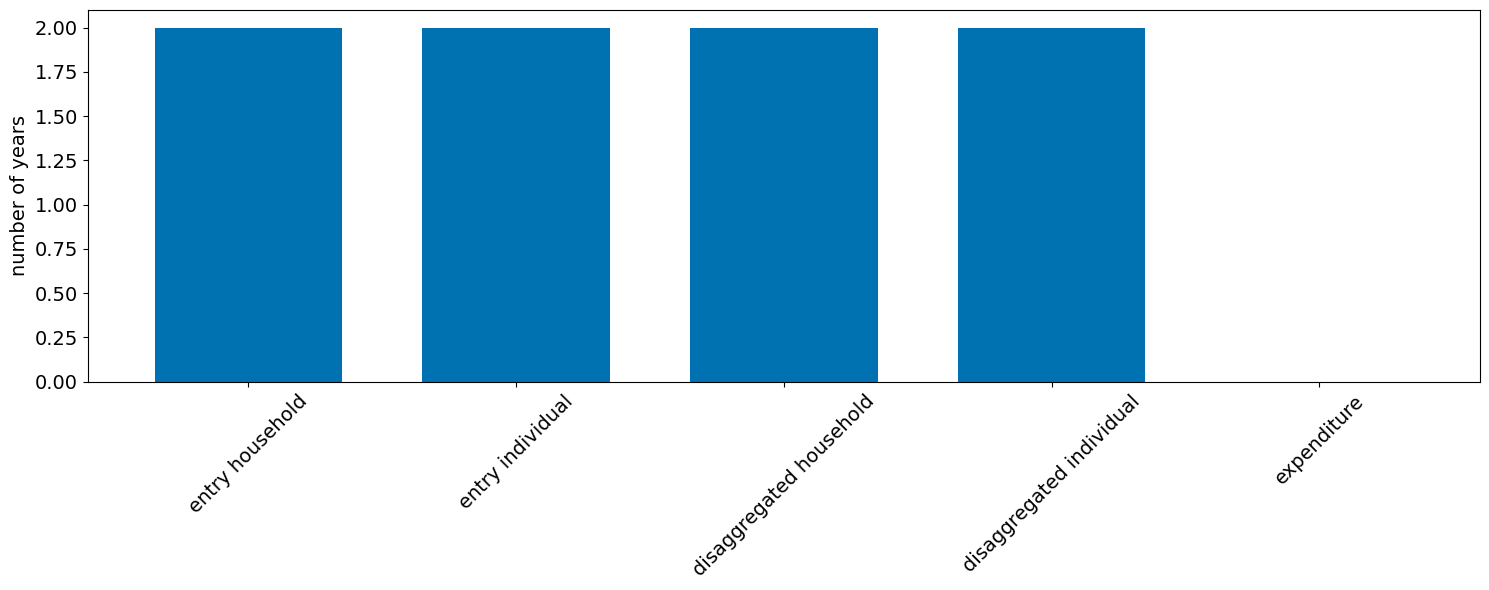

In [ ]:
# Define your custom order
custom_order = ['Europe countries','CIS countries', 'Asia & Pacific', 'The Americas', 'Arab States', 'Africa']

custom_colors = [
    '#0072B2',  # Blue
    '#CC79A7',  # Pink/Purple
    '#009E73',  # Green
    '#F0E442',  # Yellow
    '#56B4E9',  # Light Blue
    '#E69F00'  # Orange
    #'#696969'
    #'#999999',   # Grey
    ]


df_plot_t_g.plot(kind='bar',
                                                   stacked=False,
                                                   color=custom_colors,
                                                   figsize=(15, 6),
                                                   width=0.7)
#plt.title('Timeliness in 2025: average time lag of data points for indicator group in number of years (available data only)', fontsize=12)
plt.xlabel('')
plt.ylabel('number of years', fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
#plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# Step 1: Get current handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

plt.legend().remove()

# Step 2: Create a dict for easy lookup
label_to_handle = dict(zip(labels, handles))

# Make more room at the bottom
plt.subplots_adjust(bottom=0.35)  # increase as needed


plt.tight_layout()
plt.show()

# PRIORITY COUNTRIES LIST

Redo the analysis this time by counting missing values as 0 for the groups -- much easier to identify priority countries based on this.

In [ ]:
df[['entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']] = df[['entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']].fillna(0)

In [ ]:
df[['shortname',
 'regionname', 'iso3', 'new_group', 'wb_income', 'entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']][
        ((df.regionname != 'Other Economies') & (df.new_group != 'Developed-OECD') & (df.shortname.notna() )) &
        ((df.entry_household_5y <1) |
         (df.entry_individual_5y <1) |
         (df.disaggregated_household_5y <1) |
         (df.disaggregated_individual_5y <1) |
         (df.expenditure_5y <1))
        ].sort_values (by=['regionname', 'shortname']
                       ).reset_index(
    drop=True
)

,shortname,regionname,iso3,new_group,wb_income,entry_household_5y,entry_individual_5y,disaggregated_household_5y,disaggregated_individual_5y,expenditure_5y
0,Angola,Africa,AGO,SIDS + LDC,Lower middle income,0.0,0.0,0.0,0.0,0.0
1,Benin,Africa,BEN,SIDS + LDC,Lower middle income,1.0,0.0,0.0,0.0,0.0
2,Botswana,Africa,BWA,Other developing and transition,Upper middle income,0.0,0.0,0.0,0.0,0.0
3,Burkina Faso,Africa,BFA,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
4,Burundi,Africa,BDI,SIDS + LDC,Low income,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
121,Saint Vincent and the Grenadines,The Americas,VCT,SIDS + LDC,Upper middle income,0.0,0.0,0.0,0.0,0.0
122,Suriname,The Americas,SUR,SIDS + LDC,Upper middle income,0.0,0.0,0.0,0.0,0.0
123,Trinidad and Tobago,The Americas,TTO,SIDS + LDC,High income,2.0,1.0,0.0,1.0,0.0
124,Uruguay,The Americas,URY,Other developing and transition,High income,1.0,1.0,1.0,1.0,0.0


In [ ]:
# Africa only

df[['shortname',
 'regionname', 'iso3', 'new_group', 'wb_income', 'entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']][
        ((df.regionname == 'Africa') & (df.new_group != 'Developed-OECD') & (df.shortname.notna() )) &
        ((df.entry_household_5y <1) |
         (df.entry_individual_5y <1) |
         (df.disaggregated_household_5y <1) |
         (df.disaggregated_individual_5y <1) |
         (df.expenditure_5y <1))
        ].sort_values (by=['regionname', 'shortname']
                       ).reset_index(
    drop=True
)

,shortname,regionname,iso3,new_group,wb_income,entry_household_5y,entry_individual_5y,disaggregated_household_5y,disaggregated_individual_5y,expenditure_5y
0,Angola,Africa,AGO,SIDS + LDC,Lower middle income,0.0,0.0,0.0,0.0,0.0
1,Benin,Africa,BEN,SIDS + LDC,Lower middle income,1.0,0.0,0.0,0.0,0.0
2,Botswana,Africa,BWA,Other developing and transition,Upper middle income,0.0,0.0,0.0,0.0,0.0
3,Burkina Faso,Africa,BFA,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
4,Burundi,Africa,BDI,SIDS + LDC,Low income,1.0,1.0,0.0,1.0,0.0
5,Cabo Verde,Africa,CPV,SIDS + LDC,Lower middle income,0.0,0.0,0.0,0.0,0.0
6,Cameroon,Africa,CMR,Other developing and transition,Lower middle income,0.0,0.0,0.0,0.0,0.0
7,Congo (Rep. of the),Africa,COG,Other developing and transition,Lower middle income,0.0,0.0,0.0,0.0,0.0
8,Dem. Rep. of the Congo,Africa,COD,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
9,Eswatini,Africa,SWZ,Other developing and transition,Lower middle income,1.0,0.0,0.0,0.0,0.0


In [ ]:
# leave expenditure asside

df[['shortname',
 'regionname', 'iso3', 'new_group', 'wb_income', 'entry_household_5y',
    'entry_individual_5y',
    'disaggregated_household_5y',
    'disaggregated_individual_5y',
    'expenditure_5y']][
        ((df.regionname != 'Other Economies') & (df.new_group != 'Developed-OECD') & (df.shortname.notna() )) &
        ((df.entry_household_5y <1) |
         (df.entry_individual_5y <1) |
         (df.disaggregated_household_5y <1) |
         (df.disaggregated_individual_5y <1) )
        ].sort_values (by=['regionname', 'shortname']
                       ).reset_index(
    drop=True
)

,shortname,regionname,iso3,new_group,wb_income,entry_household_5y,entry_individual_5y,disaggregated_household_5y,disaggregated_individual_5y,expenditure_5y
0,Angola,Africa,AGO,SIDS + LDC,Lower middle income,0.0,0.0,0.0,0.0,0.0
1,Benin,Africa,BEN,SIDS + LDC,Lower middle income,1.0,0.0,0.0,0.0,0.0
2,Botswana,Africa,BWA,Other developing and transition,Upper middle income,0.0,0.0,0.0,0.0,0.0
3,Burkina Faso,Africa,BFA,SIDS + LDC,Low income,0.0,0.0,0.0,0.0,0.0
4,Burundi,Africa,BDI,SIDS + LDC,Low income,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
88,Saint Lucia,The Americas,LCA,SIDS + LDC,Upper middle income,0.0,0.0,0.0,0.0,0.0
89,Saint Vincent and the Grenadines,The Americas,VCT,SIDS + LDC,Upper middle income,0.0,0.0,0.0,0.0,0.0
90,Suriname,The Americas,SUR,SIDS + LDC,Upper middle income,0.0,0.0,0.0,0.0,0.0
91,Trinidad and Tobago,The Americas,TTO,SIDS + LDC,High income,2.0,1.0,0.0,1.0,0.0


In [195]:
# leave expenditure asside

df[['shortname',
 'regionname', 'iso3', 'new_group', 'wb_income', 'timeliness_entry_household',
    'timeliness_entry_individual',
    #'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    #'timeliness_expenditure'
    ]][
        ((df.regionname != 'Other Economies') & (df.new_group != 'Developed-OECD') & (df.shortname.notna() )) &
        ((df.entry_household_5y <1) |
         (df.entry_individual_5y <1) |
         (df.disaggregated_household_5y <1) |
         (df.disaggregated_individual_5y <1) )
        ].sort_values (by=['regionname', 'shortname']
                       ).reset_index(
    drop=True
).fillna(6)

,shortname,regionname,iso3,new_group,wb_income,timeliness_entry_household,timeliness_entry_individual,timeliness_disaggregated_individual
0,Angola,Africa,AGO,SIDS + LDC,Lower middle income,6,6,6
1,Benin,Africa,BEN,SIDS + LDC,Lower middle income,6,6,6
2,Botswana,Africa,BWA,Other developing and transition,Upper middle income,6,6,6
3,Burkina Faso,Africa,BFA,SIDS + LDC,Low income,6,6,6
4,Burundi,Africa,BDI,SIDS + LDC,Low income,5,5,5
...,...,...,...,...,...,...,...,...
88,Saint Lucia,The Americas,LCA,SIDS + LDC,Upper middle income,6,6,6
89,Saint Vincent and the Grenadines,The Americas,VCT,SIDS + LDC,Upper middle income,6,6,6
90,Suriname,The Americas,SUR,SIDS + LDC,Upper middle income,6,6,6
91,Trinidad and Tobago,The Americas,TTO,SIDS + LDC,High income,4,4,4


In [203]:
# leave expenditure asside

df[['shortname',
 'regionname', 'iso3', 'new_group', 'wb_income', 'timeliness_entry_household',
    'timeliness_entry_individual',
    #'timeliness_disaggregated_household',
    'timeliness_disaggregated_individual',
    #'timeliness_expenditure'
    ]][df.shortname.isin(['Philippines', 'Ukraine', 'Brazil', 'Panama', 'Peru'])].fillna(6)

,shortname,regionname,iso3,new_group,wb_income,timeliness_entry_household,timeliness_entry_individual,timeliness_disaggregated_individual
24,Brazil,The Americas,BRA,Other developing and transition,Upper middle income,2,2,2
133,Panama,The Americas,PAN,Other developing and transition,High income,6,6,6
136,Peru,The Americas,PER,Other developing and transition,Upper middle income,2,2,2
137,Philippines,Asia & Pacific,PHL,Other developing and transition,Lower middle income,3,3,3
182,Ukraine,Europe countries,UKR,Other developing and transition,Lower middle income,4,4,4


In [207]:
# to check by country if something looks off
hh_cols = [f'hh{i}' for i in range(1, 24)]
df[hh_cols][df.shortname=='Panama'].T

,133
hh1,2015
hh2,2015
hh3,2015
hh4,2019
hh5,2015
hh6,2019
hh7,2019
hh8,2012
hh9,2012
hh10,2015
